# Benchmark 1: 2D Geometric Shapes

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from enum import Enum, auto

import torch
import torch.nn as nn
import torch.nn.functional as F


class NoiseType(Enum):
    DIAGONAL = auto()
    ISOTROPIC = auto()
    ISOTROPIC_ACROSS_CLUSTERS = auto()
    FIXED = auto()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

import random
import numpy as np
import torch

def set_all_seeds(seed):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)


# Define a decorator that randomly selects one of the multi-valued outputs
def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper



Device: cpu


In [2]:
# Multi-valude function of x -> y1, y2, y3 ...
def y_circle(x, r = 1):
    y1 = np.sqrt(r - x**2)
    y2 = -np.sqrt(r - x**2)
    return y1, y2

def y_line(x, m = 1):
    return m * x, 0, -m * x

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

def y_parabola(x, a = 1):
    return a * x**2, -a * x**2


## Selecting the Shape

Please select the 2D shape for the analysis.

In [3]:
y_multi = y_hyperbola

True


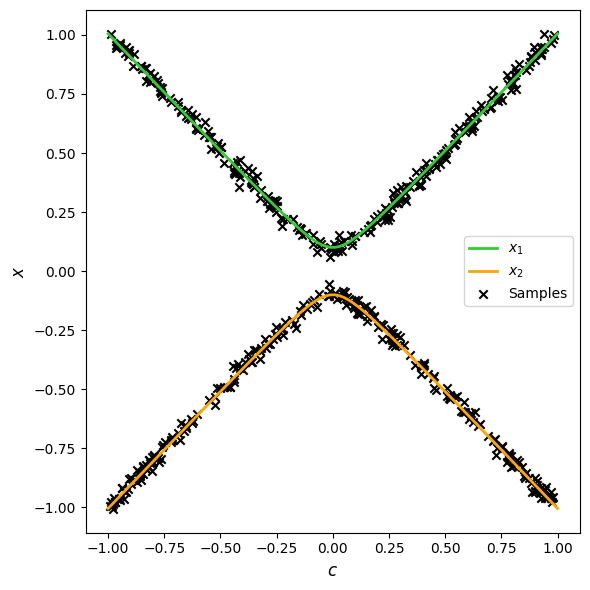

In [4]:
# Apply the rand_mod function to y_circle
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

# # If we want not conflicting data
# num_samples = 500
# x = np.random.uniform(-1, 1, num_samples)
# y = np.array([y_multi(x_i)[0] for x_i in x])

print(x.shape == y.shape)

# Load dataset
batch_size = 32
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

# Generate the global test set
test_x_vals = np.linspace(-1, 1, 100)  # Fixed test x values
test_y_vals = [y_multi(x_i) for x_i in test_x_vals]  # Corresponding true y values
test_y_vals_transposed = list(zip(*test_y_vals))  # Transpose for mode comparison

# Data bounds for counter-sample generation
y_min = torch.tensor([-1])  # Joint y_target limits (radians)
y_max = torch.tensor([1])

# Plot the function and the samples
plt.figure(figsize=(6, 6))
colors = ['limegreen', 'orange']  # Colors for the two modes

for i, (y_val, color) in enumerate(zip(y_vals_transposed, colors)):
    plt.plot(x_vals, y_val, color=color, label=f'$x_{i+1}$', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('$c$', fontsize=12)
plt.ylabel('$x$', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the figure as a high-resolution image
plt.savefig('2d_geometric_shapes.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

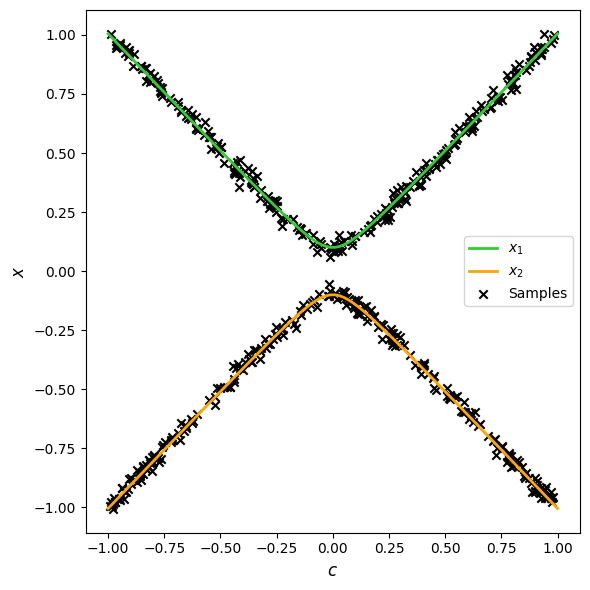

In [5]:
plt.figure(figsize=(6, 6))
colors = ['limegreen', 'orange']  # Colors for the two modes

for i, (test_y_vals, color) in enumerate(zip(test_y_vals_transposed, colors)):
    plt.plot(test_x_vals, test_y_vals, color=color, label=f'$x_{i+1}$', linewidth=2)

plt.scatter(x,y, marker='x', color='black', label='Samples')
plt.xlabel('$c$', fontsize=12)
plt.ylabel('$x$', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the figure as a high-resolution image
plt.savefig('2d_geometric_shapes.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Evaluation metrics

In [6]:
from scipy.stats import entropy, wasserstein_distance
import random
from methods.ibc import ebm_infer

def compute_metrics(generator, x_test, test_y_vals, y_func, K, model = 'Sampling', num_bins=50, tolerance=0.075, device="cpu"):
    """
    Compute mode coverage, KL divergence, and Wasserstein distance for test data.

    Args:
        generator (torch.nn.Module): The trained generator model.
        x_test (np.array): Input test values.
        test_y_vals (np.array): True y values for the test set (precomputed).
        y_func (function): Function to compute true modes for each x.
        K (int): Number of samples to generate per x.
        num_bins (int): Number of bins for histogram-based metrics.
        tolerance (float): Tolerance for mode matching.
        device (str): Device for computation.

    Returns:
        metrics (dict): Contains mode coverage, KL divergence, and Wasserstein distance.
    """
    # Step 1: Evaluate Mode Coverage and Generate Representative Test Set
    num_inputs = len(x_test)
    avg_modes_cov = 0
    num_modes_covered = 0
    generated_test_y_vals = []  # Store representative generated samples

    for i, x in enumerate(x_test):
        
        # Compute true modes for this x dynamically
        true_modes = np.array(y_func(x))
        
        if model == 'Network':
            # Predict K samples for this x
            x_tensor = torch.tensor([[x]], dtype=torch.float32).repeat(K, 1).to(device)

            generated_samples = generator.forward(x_tensor).detach().cpu().numpy().flatten()
        
        elif model == 'Sampling':
            # Sample K samples for this x
            x_tensor = torch.tensor([[x]], dtype=torch.float32).repeat(K, 1).to(device)
            z = torch.randn(K, generator.latent_size, dtype=torch.float32).to(device)

            generated_samples = generator.sample(z, x_tensor).detach().cpu().numpy().flatten()
        
        elif model == 'Generator':
            # Generate K samples for this x
            x_tensor = torch.tensor([[x]], dtype=torch.float32).repeat(K, 1).to(device)
            z = torch.randn(K, generator.latent_size, dtype=torch.float32).to(device)

            generated_samples = generator.forward(z, x_tensor).detach().cpu().numpy().flatten()
            
        elif model == 'IBC':
            generated_samples = []
            for i in range(K):
                x_tensor = torch.tensor([[x]], dtype=torch.float32).to(device)
                prediction = ebm_infer(generator, x_tensor, y_min.to(device), y_max.to(device))
                generated_samples.append(prediction)
        
        # Check if all true modes are matched within tolerance
        mode_match = [np.any(np.abs(generated_samples - mode) <= tolerance) for mode in true_modes]

        if sum(mode_match) == len(true_modes):  # All modes covered
            num_modes_covered +=  1
        avg_modes_cov +=  sum(mode_match)

        # Append one representative sample for each x to build generated_test_y_vals
        generated_test_y_vals.append(random.choice(generated_samples))  # Representative sample
            

    # Compute mode coverage
    mode_coverage = num_modes_covered / num_inputs *100 
    avg_modes_coverage = avg_modes_cov/ num_inputs
    generated_test_y_vals = np.array(generated_test_y_vals)

    # Step 2: Compute KL Divergence and Wasserstein Distance
    # Flatten test_y_vals and generated_test_y_vals for comparison
    true_y_flat = test_y_vals.flatten()
    generated_y_flat = generated_test_y_vals.flatten()

    # Compute histograms for KL divergence and Wasserstein distance
    hist_true, bins = np.histogram(true_y_flat, bins=num_bins, density=True)
    hist_generated, _ = np.histogram(generated_y_flat, bins=bins, density=True)

    # Smooth histograms to avoid zero probabilities
    hist_true += 1e-8
    hist_generated += 1e-8

    # Normalize histograms
    hist_true /= hist_true.sum()
    hist_generated /= hist_generated.sum()

    # KL Divergence
    kl_div = entropy(hist_true, hist_generated)

    # Wasserstein Distance
    w_distance = wasserstein_distance(hist_true, hist_generated)

    # Return metrics
    return {
        "Mode Coverage (%)": mode_coverage,
        "Avgerage Modes coveraged": avg_modes_coverage,
        "KL Divergence": kl_div,
        "Wasserstein Distance": w_distance,
    }



In [7]:
NUM_TRIALS = 5
TOLERANCE = 0.07

# Problem set-up Parameter


In [8]:
input_size = 1  # x, y x_input
action_size = 1  # joint y_target
condition_size = 1
output_size = 1

# EBGAN-MDN

Hyperparameter

In [9]:
# Hyperparameters
num_gaussians = 2

latent_size = 1
hidden_size = 64

num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

epoch_num_eval = 100

# Configuration parameter 
alpha = 1
dynamic_scaling_true = False
min_scale = 0.1

# Tests

In [10]:
# Initialize a new MDN generator
from methods.ebgan import EnergyModel,  generate_counter_samples
from methods.mdn import MDNGenerator, mdn_loss

In [48]:
def evaluate_model(energy_model, generator, epoch, latent_size, device, id = 0):
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5)

    # Plot the samples
    ax.scatter(x, y, marker='x', color='black', label='Original samples')

    # Random sample the query points and get the predictions using mdn_generator
    num_query_points = 200
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
    z = torch.randn(num_query_points, latent_size).to(device)

    # Generate samples from the mixture model
    predictions_mdn = generator.sample(z, query_points_tensor).detach().cpu().numpy()

    # Plot the MDN generator predictions
    ax.scatter(query_points, predictions_mdn, marker='o', color='red', label='MDN Generator Predictions', alpha=0.9)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.grid()
    ax.legend()
    # plt.title(f"Evaluation at Epoch {epoch}")
    plt.savefig(f'images/EBM_MDN_{id}_extra_1.png', dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
from methods.ebgan_mdn import train_ebgan_mdn

def train_and_evaluate(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_min, y_max, 
                       neg_count, repeat_energy_updates, device, alpha, dynamic_scaling_true, min_scale, y_multi):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        ebgan_mdn_generator = MDNGenerator(latent_size, hidden_size, output_size, num_gaussians, condition_size).to(device)
        ebgan_energy_model = EnergyModel(condition_size, output_size, hidden_size).to(device)

        # Optimizer
        optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
        optimizer_ebgan_g = optim.Adam(ebgan_mdn_generator.parameters(), lr=learning_rate_g)
        scheduler_e = optim.lr_scheduler.StepLR(optimizer_ebgan_e, step_size=20, gamma=0.5)
        scheduler_g = optim.lr_scheduler.StepLR(optimizer_ebgan_g, step_size=20, gamma=0.5)
        
        # Train the model
        train_ebgan_mdn(dataloader, ebgan_energy_model, ebgan_mdn_generator, optimizer_ebgan_e, optimizer_ebgan_g, 
                        scheduler_e, scheduler_g, num_epochs, None, y_min, y_max, neg_count, 
                        repeat_energy_updates, device, alpha, dynamic_scaling_true, min_scale)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics  
        metrics = compute_metrics(ebgan_mdn_generator, test_x_vals, true_y_flat , y_multi, K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])

        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        
        evaluate_model(ebgan_energy_model, ebgan_mdn_generator, num_epochs, ebgan_mdn_generator.latent_size, device, trial)
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results



=== Training Run 1 ===
Epoch [1/100], Energy Loss: 3.4830, Generator Loss: 0.2067, Generator Energy Loss: 0.0082, Generator MDN Loss: 0.1984
Epoch [2/100], Energy Loss: 3.2854, Generator Loss: 0.1304, Generator Energy Loss: 0.0420, Generator MDN Loss: 0.0884
Epoch [3/100], Energy Loss: 2.9568, Generator Loss: -0.0485, Generator Energy Loss: -0.0763, Generator MDN Loss: 0.0277
Epoch [4/100], Energy Loss: 2.6099, Generator Loss: -0.0411, Generator Energy Loss: -0.0826, Generator MDN Loss: 0.0415
Epoch [5/100], Energy Loss: 2.3693, Generator Loss: 0.4258, Generator Energy Loss: 0.3628, Generator MDN Loss: 0.0630
Epoch [6/100], Energy Loss: 2.1922, Generator Loss: 0.9152, Generator Energy Loss: 0.8904, Generator MDN Loss: 0.0248
Epoch [7/100], Energy Loss: 2.0665, Generator Loss: 1.1850, Generator Energy Loss: 1.1683, Generator MDN Loss: 0.0167
Epoch [8/100], Energy Loss: 1.9823, Generator Loss: 1.7124, Generator Energy Loss: 1.6849, Generator MDN Loss: 0.0275
Epoch [9/100], Energy Loss: 

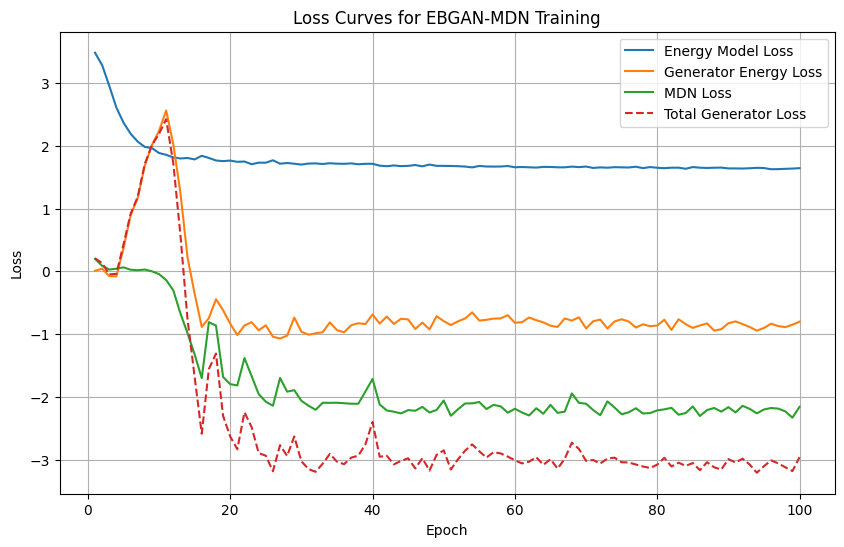

Run 1 - KL Divergence: 3.0548, Wasserstein Distance: 0.0079, Mode Coverage (%): 98.0, Avgerage Modes coveraged: 1.98


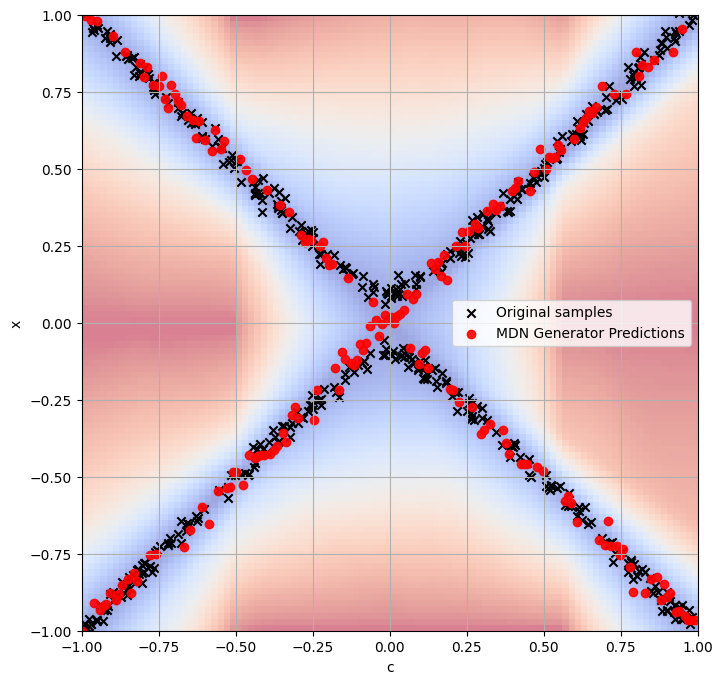


=== Training Run 2 ===
Epoch [1/100], Energy Loss: 3.4846, Generator Loss: 0.2570, Generator Energy Loss: 0.1551, Generator MDN Loss: 0.1019
Epoch [2/100], Energy Loss: 3.3358, Generator Loss: 0.2045, Generator Energy Loss: 0.1764, Generator MDN Loss: 0.0281
Epoch [3/100], Energy Loss: 3.0665, Generator Loss: 0.5194, Generator Energy Loss: 0.5027, Generator MDN Loss: 0.0167
Epoch [4/100], Energy Loss: 2.8313, Generator Loss: 0.8686, Generator Energy Loss: 0.8729, Generator MDN Loss: -0.0043
Epoch [5/100], Energy Loss: 2.6493, Generator Loss: 1.0193, Generator Energy Loss: 1.0339, Generator MDN Loss: -0.0146
Epoch [6/100], Energy Loss: 2.5131, Generator Loss: 1.6024, Generator Energy Loss: 1.6170, Generator MDN Loss: -0.0146
Epoch [7/100], Energy Loss: 2.3857, Generator Loss: 1.6074, Generator Energy Loss: 1.6318, Generator MDN Loss: -0.0244
Epoch [8/100], Energy Loss: 2.2824, Generator Loss: 2.1178, Generator Energy Loss: 2.1727, Generator MDN Loss: -0.0548
Epoch [9/100], Energy Loss:

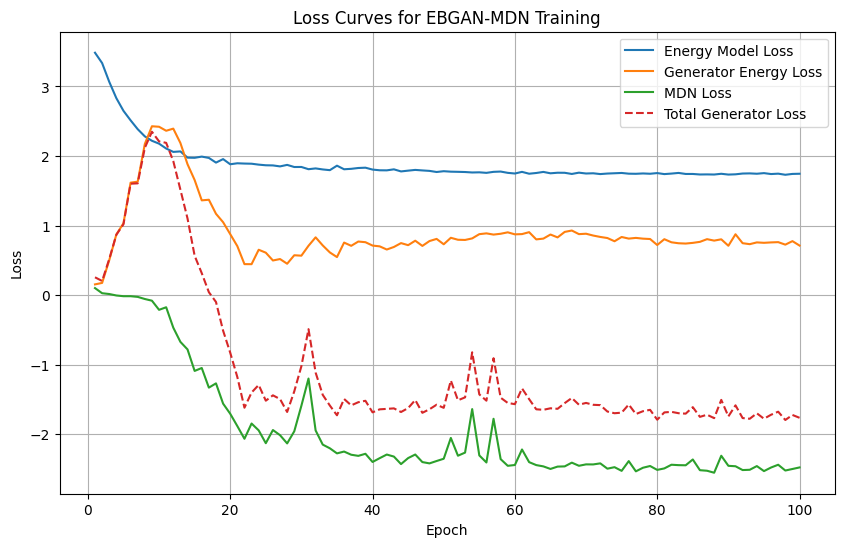

Run 2 - KL Divergence: 2.0261, Wasserstein Distance: 0.0074, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


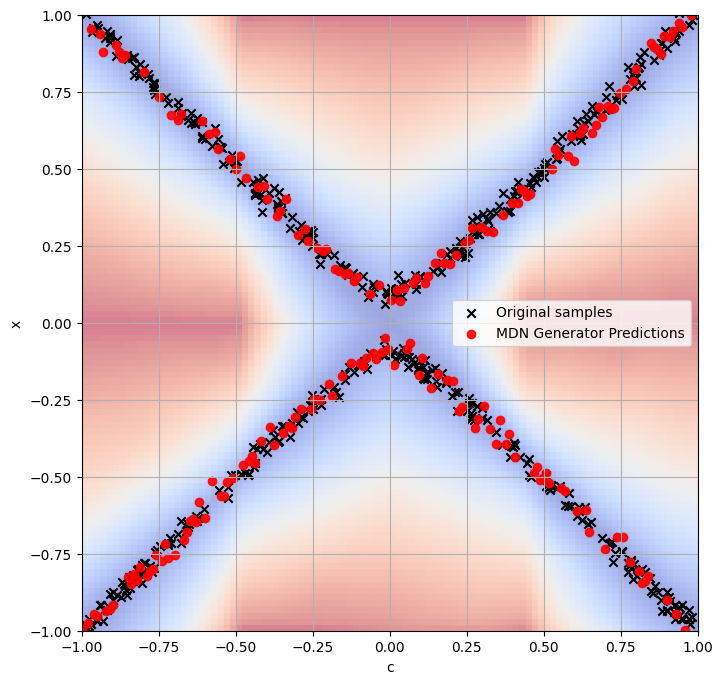


=== Training Run 3 ===
Epoch [1/100], Energy Loss: 3.4925, Generator Loss: 0.3539, Generator Energy Loss: 0.1737, Generator MDN Loss: 0.1802
Epoch [2/100], Energy Loss: 3.3323, Generator Loss: 0.3566, Generator Energy Loss: 0.2795, Generator MDN Loss: 0.0771
Epoch [3/100], Energy Loss: 3.0312, Generator Loss: 0.5988, Generator Energy Loss: 0.5598, Generator MDN Loss: 0.0391
Epoch [4/100], Energy Loss: 2.7224, Generator Loss: 0.9595, Generator Energy Loss: 0.9126, Generator MDN Loss: 0.0468
Epoch [5/100], Energy Loss: 2.4865, Generator Loss: 1.2639, Generator Energy Loss: 1.2439, Generator MDN Loss: 0.0200
Epoch [6/100], Energy Loss: 2.3576, Generator Loss: 1.6409, Generator Energy Loss: 1.5818, Generator MDN Loss: 0.0591
Epoch [7/100], Energy Loss: 2.2227, Generator Loss: 1.7859, Generator Energy Loss: 1.7683, Generator MDN Loss: 0.0176
Epoch [8/100], Energy Loss: 2.1793, Generator Loss: 2.2526, Generator Energy Loss: 2.2805, Generator MDN Loss: -0.0279
Epoch [9/100], Energy Loss: 2.0

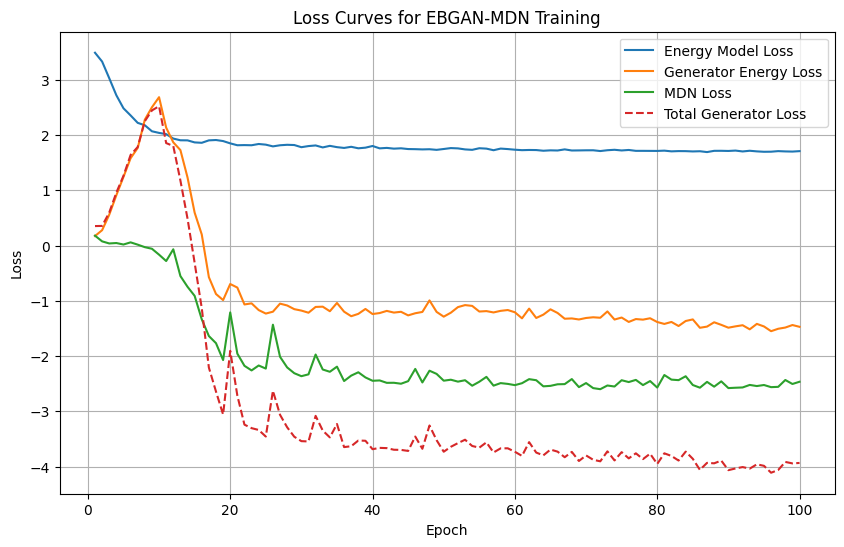

Run 3 - KL Divergence: 1.6475, Wasserstein Distance: 0.0067, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


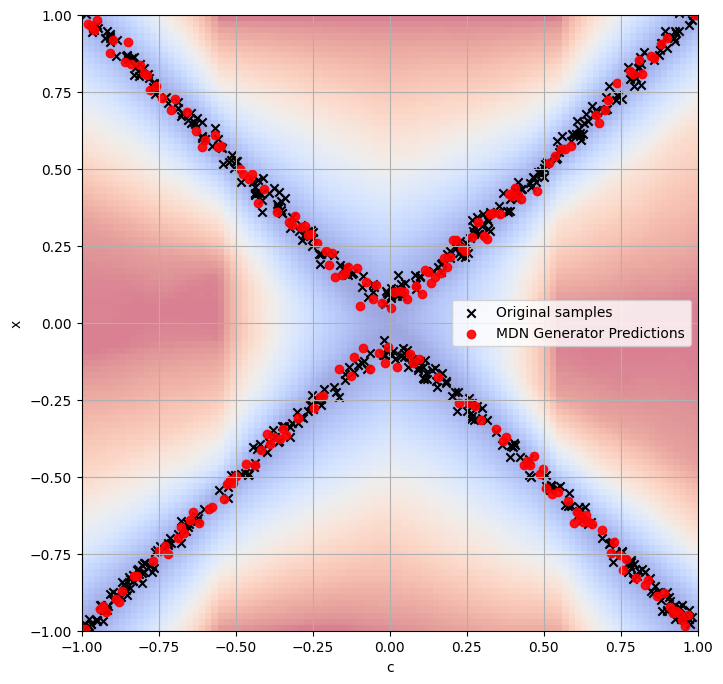


=== Training Run 4 ===
Epoch [1/100], Energy Loss: 3.4828, Generator Loss: 0.1801, Generator Energy Loss: -0.0892, Generator MDN Loss: 0.2694
Epoch [2/100], Energy Loss: 3.2692, Generator Loss: 0.2486, Generator Energy Loss: 0.1099, Generator MDN Loss: 0.1387
Epoch [3/100], Energy Loss: 2.8536, Generator Loss: 0.7725, Generator Energy Loss: 0.7083, Generator MDN Loss: 0.0643
Epoch [4/100], Energy Loss: 2.5391, Generator Loss: 1.3714, Generator Energy Loss: 1.3357, Generator MDN Loss: 0.0357
Epoch [5/100], Energy Loss: 2.3300, Generator Loss: 2.1357, Generator Energy Loss: 2.1150, Generator MDN Loss: 0.0208
Epoch [6/100], Energy Loss: 2.2191, Generator Loss: 2.8975, Generator Energy Loss: 2.8838, Generator MDN Loss: 0.0137
Epoch [7/100], Energy Loss: 2.1229, Generator Loss: 3.1523, Generator Energy Loss: 3.2512, Generator MDN Loss: -0.0989
Epoch [8/100], Energy Loss: 2.0683, Generator Loss: 3.5326, Generator Energy Loss: 3.6737, Generator MDN Loss: -0.1411
Epoch [9/100], Energy Loss: 1

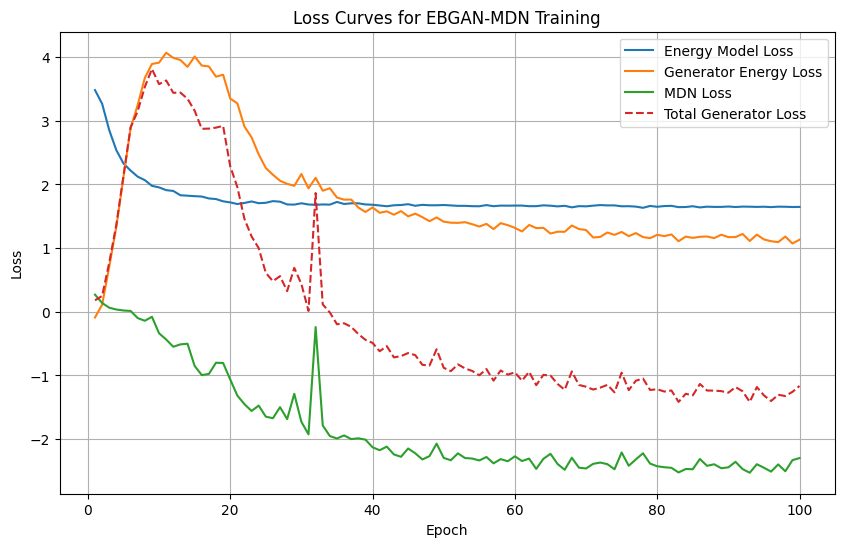

Run 4 - KL Divergence: 2.3901, Wasserstein Distance: 0.0091, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


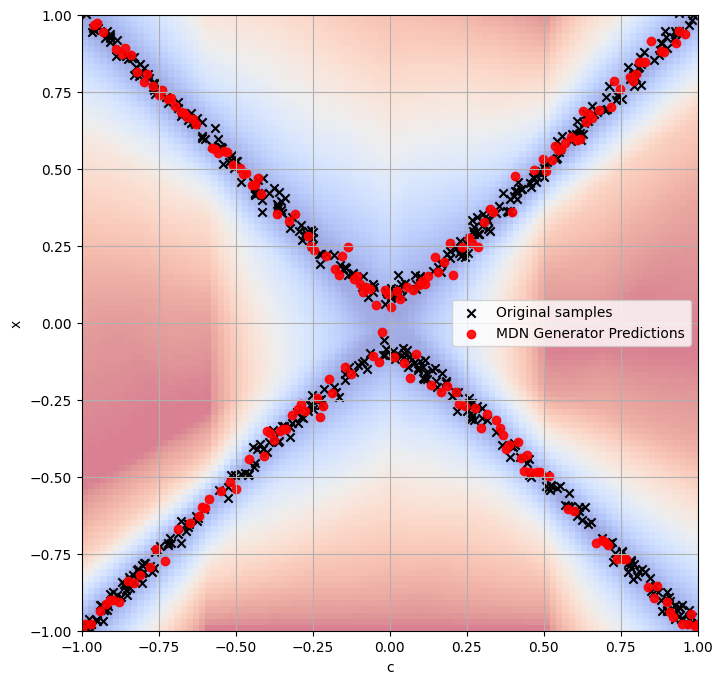


=== Training Run 5 ===
Epoch [1/100], Energy Loss: 3.4889, Generator Loss: 0.3352, Generator Energy Loss: 0.1454, Generator MDN Loss: 0.1898
Epoch [2/100], Energy Loss: 3.2837, Generator Loss: 0.1322, Generator Energy Loss: 0.0578, Generator MDN Loss: 0.0744
Epoch [3/100], Energy Loss: 2.9486, Generator Loss: 0.1801, Generator Energy Loss: 0.1441, Generator MDN Loss: 0.0359
Epoch [4/100], Energy Loss: 2.6354, Generator Loss: 0.6076, Generator Energy Loss: 0.5753, Generator MDN Loss: 0.0322
Epoch [5/100], Energy Loss: 2.4358, Generator Loss: 0.8176, Generator Energy Loss: 0.7949, Generator MDN Loss: 0.0227
Epoch [6/100], Energy Loss: 2.3207, Generator Loss: 1.1375, Generator Energy Loss: 1.1640, Generator MDN Loss: -0.0265
Epoch [7/100], Energy Loss: 2.2541, Generator Loss: 1.8900, Generator Energy Loss: 1.9355, Generator MDN Loss: -0.0455
Epoch [8/100], Energy Loss: 2.1292, Generator Loss: 1.8779, Generator Energy Loss: 1.9649, Generator MDN Loss: -0.0870
Epoch [9/100], Energy Loss: 2

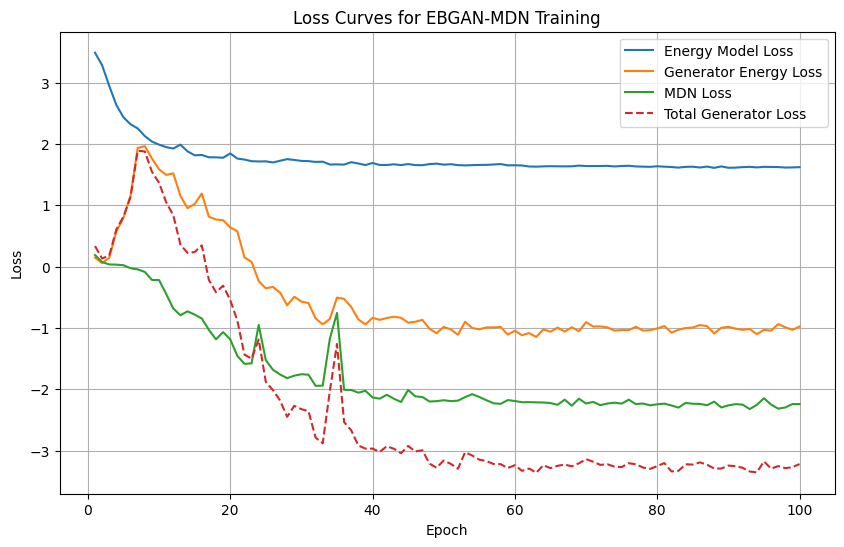

Run 5 - KL Divergence: 1.4091, Wasserstein Distance: 0.0067, Mode Coverage (%): 99.0, Avgerage Modes coveraged: 1.99


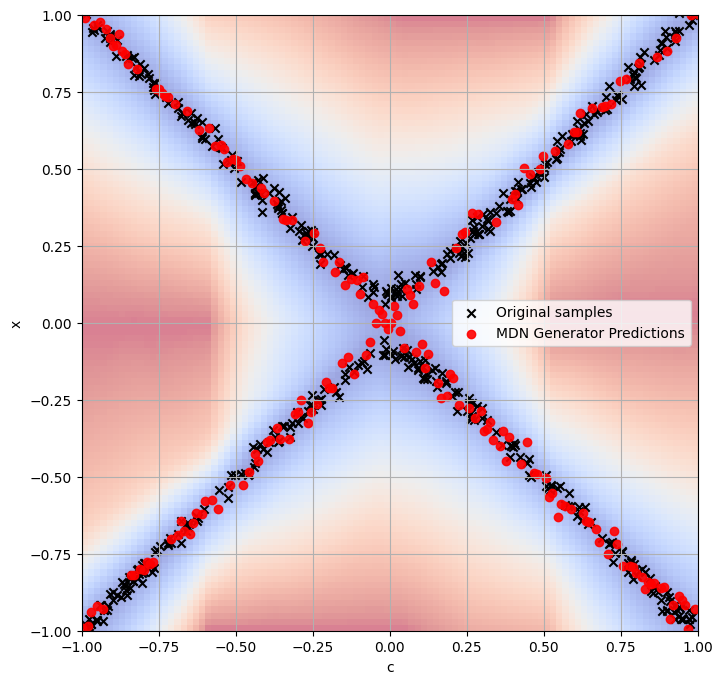

KL Divergence: 2.1055 ± 0.5802
Wasserstein Distance: 0.0076 ± 0.0009
Mode Coverage (%): 99.4000 ± 0.8000
Avgerage Modes coveraged: 1.9940 ± 0.0080


In [13]:
metrics_results = train_and_evaluate(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_min=y_min,
    y_max=y_max,
    neg_count=neg_count,
    repeat_energy_updates=repeat_energy_updates,
    device=device,
    alpha=alpha,
    dynamic_scaling_true=dynamic_scaling_true,
    min_scale=min_scale,
    y_multi = y_multi
)

In [49]:
# Hyperparameters
num_gaussians = 3

latent_size = 1
hidden_size = 64

num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

epoch_num_eval = 100

# Configuration parameter 
alpha = 1
dynamic_scaling_true = False
min_scale = 0.1

In [ ]:
metrics_results = train_and_evaluate(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_min=y_min,
    y_max=y_max,
    neg_count=neg_count,
    repeat_energy_updates=repeat_energy_updates,
    device=device,
    alpha=alpha,
    dynamic_scaling_true=dynamic_scaling_true,
    min_scale=min_scale,
    y_multi = y_multi
)


=== Training Run 1 ===
Epoch [1/100], Energy Loss: 3.4714, Generator Loss: 0.1949, Generator Energy Loss: 0.0784, Generator MDN Loss: 0.1165
Epoch [2/100], Energy Loss: 2.9025, Generator Loss: 0.6613, Generator Energy Loss: 0.6216, Generator MDN Loss: 0.0398
Epoch [3/100], Energy Loss: 2.2898, Generator Loss: 1.7312, Generator Energy Loss: 1.7216, Generator MDN Loss: 0.0096
Epoch [4/100], Energy Loss: 1.9787, Generator Loss: 3.6759, Generator Energy Loss: 3.6524, Generator MDN Loss: 0.0235
Epoch [5/100], Energy Loss: 1.8794, Generator Loss: 4.2033, Generator Energy Loss: 4.1780, Generator MDN Loss: 0.0253
Epoch [6/100], Energy Loss: 1.7991, Generator Loss: 5.3113, Generator Energy Loss: 5.3597, Generator MDN Loss: -0.0484
Epoch [7/100], Energy Loss: 1.7069, Generator Loss: 6.0795, Generator Energy Loss: 6.1663, Generator MDN Loss: -0.0868
Epoch [8/100], Energy Loss: 1.7337, Generator Loss: 6.1051, Generator Energy Loss: 6.1562, Generator MDN Loss: -0.0511
Epoch [9/100], Energy Loss: 1

In [ ]:
# Hyperparameters
num_gaussians = 1

latent_size = 1
hidden_size = 64

num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

epoch_num_eval = 100

# Configuration parameter 
alpha = 1
dynamic_scaling_true = False
min_scale = 0.1

In [ ]:
metrics_results = train_and_evaluate(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_min=y_min,
    y_max=y_max,
    neg_count=neg_count,
    repeat_energy_updates=repeat_energy_updates,
    device=device,
    alpha=alpha,
    dynamic_scaling_true=dynamic_scaling_true,
    min_scale=min_scale,
    y_multi = y_multi
)

### Visualization of results and Training progress

Adapting the training loop for visualization

In [14]:
def evaluate_model_clean(energy_model, generator, epoch, latent_size, device, show_energy_map=True, output_path=None):
    """
    Visualize the generator predictions and optionally the energy map.
    
    Args:
        energy_model (torch.nn.Module): The trained energy model.
        generator (torch.nn.Module): The trained generator model.
        epoch (int): Current epoch for visualization.
        latent_size (int): Latent size for the generator.
        device (str): Device to perform computations on.
        show_energy_map (bool): Whether to display the energy map as a background.
        output_path (str): Path to save the figure. If None, displays the figure instead.
    """
    # Generate grid points for the energy map
    if show_energy_map:
        x_range = np.linspace(-1, 1, 100)
        y_range = np.linspace(-1, 1, 100)
        grid_x, grid_y = np.meshgrid(x_range, y_range)
        grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

        # Compute energy model output for each grid point
        energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
        energy_outputs = energy_outputs.reshape(100, 100)

        # Normalize the heatmap values
        energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))
    
    # Generate predictions using the generator
    num_query_points = 200
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
    z = torch.randn(num_query_points, latent_size).to(device)

    predictions_mdn = generator.sample(z, query_points_tensor).detach().cpu().numpy()

    # Plot the figure
    fig, ax = plt.subplots(figsize=(6, 6))

    if show_energy_map:
        # Plot the energy heatmap
        ax.imshow(
            energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5
        )

    # Plot generator predictions
    ax.scatter(query_points, predictions_mdn, marker='o', color='red', alpha=0.9)

    # Remove axes, borders, and grid for a clean figure
    ax.set_axis_off()

    # Save or display the figure
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()

    plt.close(fig)


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset
from methods.ebgan_mdn import info_nce_loss, dynamic_scaling

# Training loop combining energy model with MDN generator
def train_ebgan_mdn_with_visualization(dataloader, energy_model, generator, optimizer_e, optimizer_g, 
                    scheduler_e, scheduler_g, num_epochs, writer, 
                    y_min, y_max, neg_count, repeat_energy_updates, device, 
                    alpha = 1, dynamic_scaling_true = False,
                    min_scale = 0.1, epoch_num_eval = 25):
    energy_model.train()
    generator.train()
    # Initialize lists to track losses
    energy_losses = []
    generator_e_losses = []
    mdn_losses = []
    total_g_losses = []

    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss_e = 0.0
        epoch_g_loss_mdn = 0.0
        epoch_g_loss = 0.0
        
        if dynamic_scaling_true:
            alpha = dynamic_scaling(epoch, num_epochs, min_scale)
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)

            for _ in range(repeat_energy_updates):
                # Draw noise samples
                z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            
                # Generate fake samples
                fake_y_target = generator.sample(z, x_input)
                
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Compute loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples, fake_y_target, alpha)
                
                # Backpropagation
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()

            # Compute energy 
            z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            fake_y_target = generator.sample(z, x_input)
            g_loss_e = energy_model(x_input, fake_y_target).mean()

            # Compute MDN loss
            log_pi, mu, sigma = generator(z, x_input)
            mdn_g_loss = mdn_loss(log_pi, mu, sigma, y_target)

            epoch_g_loss_e += g_loss_e.item()
            epoch_g_loss_mdn += mdn_g_loss.item()
            
            # Combined loss
            g_loss = g_loss_e + mdn_g_loss
            
            epoch_g_loss += g_loss.item()

            # Backpropagation
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            # Log losses
            # writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            # writer.add_scalar('Loss/GeneratorE', g_loss_e.item(), epoch * len(dataloader) + i)
            # writer.add_scalar('Loss/MDN', mdn_g_loss.item(), epoch * len(dataloader) + i)
            # writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)

        scheduler_e.step()
        scheduler_g.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss_e = epoch_g_loss_e / len(dataloader)
        avg_g_loss_mdn = epoch_g_loss_mdn / len(dataloader)
        avg_g_loss = epoch_g_loss / len(dataloader)
        
        # Store losses for plotting
        energy_losses.append(avg_e_loss)
        generator_e_losses.append(avg_g_loss_e)
        mdn_losses.append(avg_g_loss_mdn)
        total_g_losses.append(avg_g_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Energy Loss: {avg_e_loss:.4f}, "
                f"Generator Loss: {avg_g_loss:.4f}, "
                f"Generator Energy Loss: {avg_g_loss_e:.4f}, "
                f"Generator MDN Loss: {avg_g_loss_mdn:.4f}"
                )
        
        # Evaluate model every 20 epochs
        if (epoch + 1) % epoch_num_eval == 0:
            evaluate_model(energy_model, generator, epoch + 1, generator.latent_size, device)
            evaluate_model_clean(
                energy_model=energy_model,
                generator=generator,
                epoch=epoch + 1,
                latent_size=generator.latent_size,
                device=device,
                show_energy_map=False,
                output_path=None
            )
        
    # Plot the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), energy_losses, label='Energy Model Loss')
    plt.plot(range(1, num_epochs + 1), generator_e_losses, label='Generator Energy Loss')
    plt.plot(range(1, num_epochs + 1), mdn_losses, label='MDN Loss')
    plt.plot(range(1, num_epochs + 1), total_g_losses, label='Total Generator Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves for EBGAN-MDN Training')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
ebgan_mdn_generator = MDNGenerator(latent_size, hidden_size, output_size, num_gaussians, condition_size).to(device)
ebgan_energy_model = EnergyModel(condition_size, output_size, hidden_size).to(device)

# Optimizer
optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
optimizer_ebgan_g = optim.Adam(ebgan_mdn_generator.parameters(), lr=learning_rate_g)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_ebgan_e, step_size=20, gamma=0.5)
scheduler_g = optim.lr_scheduler.StepLR(optimizer_ebgan_g, step_size=20, gamma=0.5)


In [17]:
epoch_num_eval = 10

Epoch [1/100], Energy Loss: 3.4849, Generator Loss: 0.0593, Generator Energy Loss: -0.0674, Generator MDN Loss: 0.1267
Epoch [2/100], Energy Loss: 3.2880, Generator Loss: -0.1011, Generator Energy Loss: -0.1439, Generator MDN Loss: 0.0428
Epoch [3/100], Energy Loss: 2.9636, Generator Loss: -0.2496, Generator Energy Loss: -0.2650, Generator MDN Loss: 0.0154
Epoch [4/100], Energy Loss: 2.7001, Generator Loss: -0.1842, Generator Energy Loss: -0.2023, Generator MDN Loss: 0.0181
Epoch [5/100], Energy Loss: 2.4670, Generator Loss: 0.1411, Generator Energy Loss: 0.1474, Generator MDN Loss: -0.0063
Epoch [6/100], Energy Loss: 2.3207, Generator Loss: 0.5677, Generator Energy Loss: 0.5821, Generator MDN Loss: -0.0144
Epoch [7/100], Energy Loss: 2.1975, Generator Loss: 0.8559, Generator Energy Loss: 0.8832, Generator MDN Loss: -0.0273
Epoch [8/100], Energy Loss: 2.0907, Generator Loss: 1.2618, Generator Energy Loss: 1.2929, Generator MDN Loss: -0.0311
Epoch [9/100], Energy Loss: 2.0261, Generator

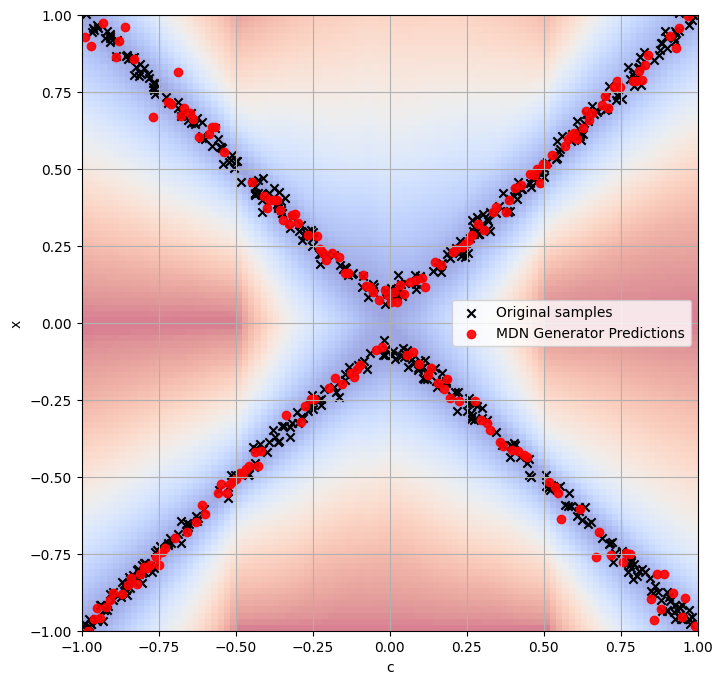

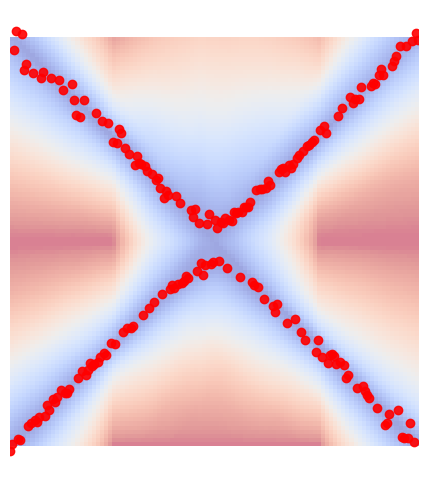

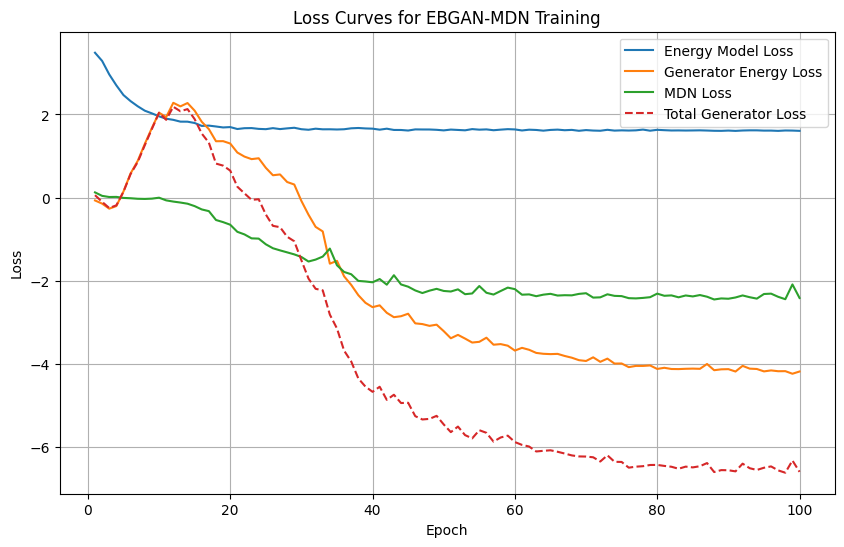

In [20]:
train_ebgan_mdn_with_visualization(dataloader, ebgan_energy_model, ebgan_mdn_generator, optimizer_ebgan_e, optimizer_ebgan_g, 
                    scheduler_e, scheduler_g, num_epochs, None,
                    y_min, y_max, neg_count, repeat_energy_updates, device, 
                    alpha, dynamic_scaling_true,
                    min_scale, epoch_num_eval)

# Other models

## 1. Explicit BC

In [18]:
# Hyperparameters

hidden_size = 64

num_epochs = 100
batch_size = 32
learning_rate = 0.001

In [19]:

def visulize_outcomes(mlp, y_multi, id = 0):
    # Random sample the query points and get the predictions
    num_query_points = 100
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
    predictions = mlp(query_points_tensor).detach().numpy()

    # Plot the function, samples, and predictions
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the true functions
    colors = ['limegreen', 'orange']  # Colors for the two modes

    # for i, (y_val, color) in enumerate(zip(y_vals_transposed, colors)):
    #     plt.plot(x_vals, y_val, color=color, label=f'Target {i+1}: $y_{i+1}(x)$', linewidth=2)
    
    # Plot samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.9)
    
    # Remove grid
    ax.grid(False)
    
    # Set labels and legend
    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.legend(loc='center left', bbox_to_anchor=(0.77, 0.55))
    
    # Show or save the plot
    plt.savefig(f'images/Explicit_BC_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [20]:
from methods.mlp import MLP, train
def train_and_evaluate_nn(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate, hidden_size):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        mlp = MLP(input_size, hidden_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        
        # Train the model
        train(mlp, dataloader, criterion, optimizer, scheduler, num_epochs, writer = None)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics  
        metrics = compute_metrics(mlp, test_x_vals, true_y_flat , y_multi, model =  'Network', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        visulize_outcomes(mlp, y_multi, trial)
        
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results

### Tests 


=== Training Run 1 ===
Epoch [1/100], Loss: 0.3732, LR: 0.001000
Epoch [2/100], Loss: 0.3621, LR: 0.001000
Epoch [3/100], Loss: 0.3650, LR: 0.001000
Epoch [4/100], Loss: 0.3647, LR: 0.001000
Epoch [5/100], Loss: 0.3632, LR: 0.001000
Epoch [6/100], Loss: 0.3599, LR: 0.001000
Epoch [7/100], Loss: 0.3638, LR: 0.001000
Epoch [8/100], Loss: 0.3610, LR: 0.001000
Epoch [9/100], Loss: 0.3580, LR: 0.001000
Epoch [10/100], Loss: 0.3625, LR: 0.001000
Epoch [11/100], Loss: 0.3585, LR: 0.001000
Epoch [12/100], Loss: 0.3633, LR: 0.001000
Epoch [13/100], Loss: 0.3650, LR: 0.001000
Epoch [14/100], Loss: 0.3576, LR: 0.001000
Epoch [15/100], Loss: 0.3566, LR: 0.001000
Epoch [16/100], Loss: 0.3621, LR: 0.001000
Epoch [17/100], Loss: 0.3606, LR: 0.001000
Epoch [18/100], Loss: 0.3562, LR: 0.001000
Epoch [19/100], Loss: 0.3559, LR: 0.001000
Epoch [20/100], Loss: 0.3586, LR: 0.000500
Epoch [21/100], Loss: 0.3551, LR: 0.000500
Epoch [22/100], Loss: 0.3565, LR: 0.000500
Epoch [23/100], Loss: 0.3543, LR: 0.000

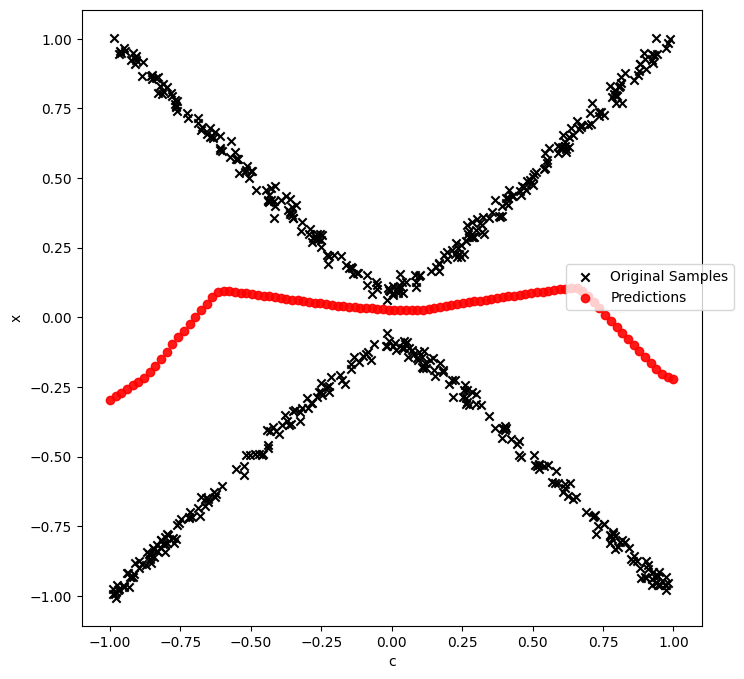


=== Training Run 2 ===
Epoch [1/100], Loss: 0.3680, LR: 0.001000
Epoch [2/100], Loss: 0.3632, LR: 0.001000
Epoch [3/100], Loss: 0.3661, LR: 0.001000
Epoch [4/100], Loss: 0.3611, LR: 0.001000
Epoch [5/100], Loss: 0.3624, LR: 0.001000
Epoch [6/100], Loss: 0.3629, LR: 0.001000
Epoch [7/100], Loss: 0.3619, LR: 0.001000
Epoch [8/100], Loss: 0.3586, LR: 0.001000
Epoch [9/100], Loss: 0.3615, LR: 0.001000
Epoch [10/100], Loss: 0.3598, LR: 0.001000
Epoch [11/100], Loss: 0.3592, LR: 0.001000
Epoch [12/100], Loss: 0.3607, LR: 0.001000
Epoch [13/100], Loss: 0.3616, LR: 0.001000
Epoch [14/100], Loss: 0.3543, LR: 0.001000
Epoch [15/100], Loss: 0.3587, LR: 0.001000
Epoch [16/100], Loss: 0.3590, LR: 0.001000
Epoch [17/100], Loss: 0.3580, LR: 0.001000
Epoch [18/100], Loss: 0.3622, LR: 0.001000
Epoch [19/100], Loss: 0.3561, LR: 0.001000
Epoch [20/100], Loss: 0.3563, LR: 0.000500
Epoch [21/100], Loss: 0.3551, LR: 0.000500
Epoch [22/100], Loss: 0.3548, LR: 0.000500
Epoch [23/100], Loss: 0.3549, LR: 0.000

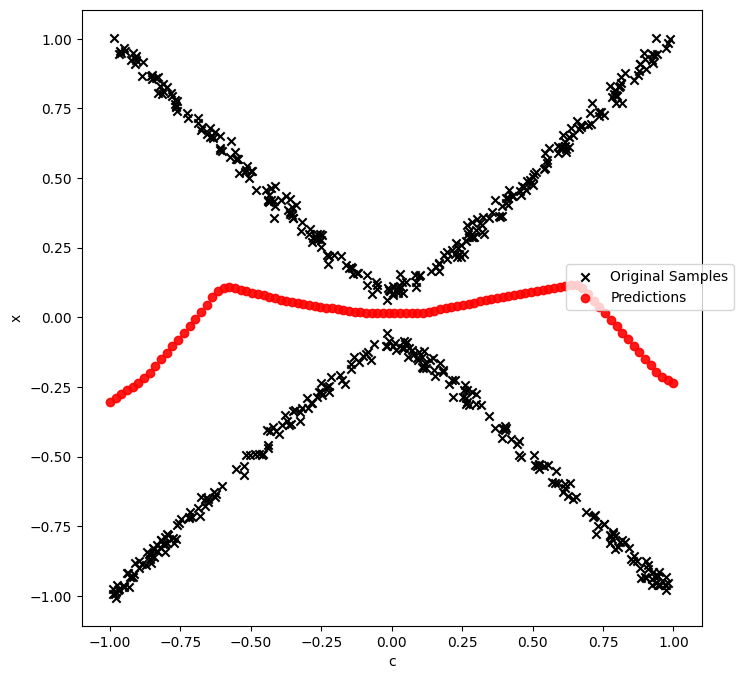


=== Training Run 3 ===
Epoch [1/100], Loss: 0.3723, LR: 0.001000
Epoch [2/100], Loss: 0.3634, LR: 0.001000
Epoch [3/100], Loss: 0.3663, LR: 0.001000
Epoch [4/100], Loss: 0.3634, LR: 0.001000
Epoch [5/100], Loss: 0.3618, LR: 0.001000
Epoch [6/100], Loss: 0.3616, LR: 0.001000
Epoch [7/100], Loss: 0.3652, LR: 0.001000
Epoch [8/100], Loss: 0.3629, LR: 0.001000
Epoch [9/100], Loss: 0.3595, LR: 0.001000
Epoch [10/100], Loss: 0.3595, LR: 0.001000
Epoch [11/100], Loss: 0.3594, LR: 0.001000
Epoch [12/100], Loss: 0.3539, LR: 0.001000
Epoch [13/100], Loss: 0.3609, LR: 0.001000
Epoch [14/100], Loss: 0.3577, LR: 0.001000
Epoch [15/100], Loss: 0.3623, LR: 0.001000
Epoch [16/100], Loss: 0.3567, LR: 0.001000
Epoch [17/100], Loss: 0.3554, LR: 0.001000
Epoch [18/100], Loss: 0.3582, LR: 0.001000
Epoch [19/100], Loss: 0.3547, LR: 0.001000
Epoch [20/100], Loss: 0.3555, LR: 0.000500
Epoch [21/100], Loss: 0.3545, LR: 0.000500
Epoch [22/100], Loss: 0.3558, LR: 0.000500
Epoch [23/100], Loss: 0.3527, LR: 0.000

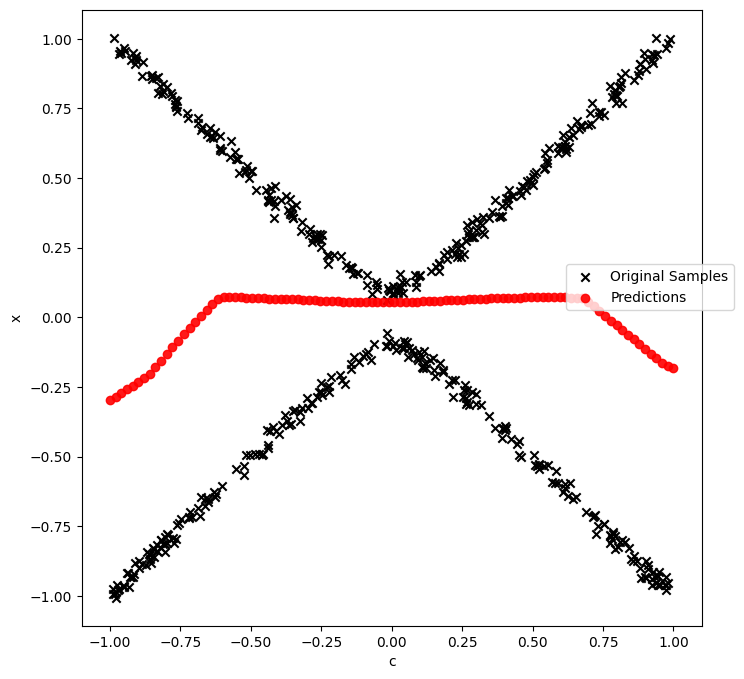


=== Training Run 4 ===
Epoch [1/100], Loss: 0.3681, LR: 0.001000
Epoch [2/100], Loss: 0.3656, LR: 0.001000
Epoch [3/100], Loss: 0.3644, LR: 0.001000
Epoch [4/100], Loss: 0.3628, LR: 0.001000
Epoch [5/100], Loss: 0.3609, LR: 0.001000
Epoch [6/100], Loss: 0.3630, LR: 0.001000
Epoch [7/100], Loss: 0.3585, LR: 0.001000
Epoch [8/100], Loss: 0.3633, LR: 0.001000
Epoch [9/100], Loss: 0.3689, LR: 0.001000
Epoch [10/100], Loss: 0.3589, LR: 0.001000
Epoch [11/100], Loss: 0.3593, LR: 0.001000
Epoch [12/100], Loss: 0.3626, LR: 0.001000
Epoch [13/100], Loss: 0.3568, LR: 0.001000
Epoch [14/100], Loss: 0.3561, LR: 0.001000
Epoch [15/100], Loss: 0.3592, LR: 0.001000
Epoch [16/100], Loss: 0.3557, LR: 0.001000
Epoch [17/100], Loss: 0.3581, LR: 0.001000
Epoch [18/100], Loss: 0.3563, LR: 0.001000
Epoch [19/100], Loss: 0.3563, LR: 0.001000
Epoch [20/100], Loss: 0.3599, LR: 0.000500
Epoch [21/100], Loss: 0.3581, LR: 0.000500
Epoch [22/100], Loss: 0.3533, LR: 0.000500
Epoch [23/100], Loss: 0.3527, LR: 0.000

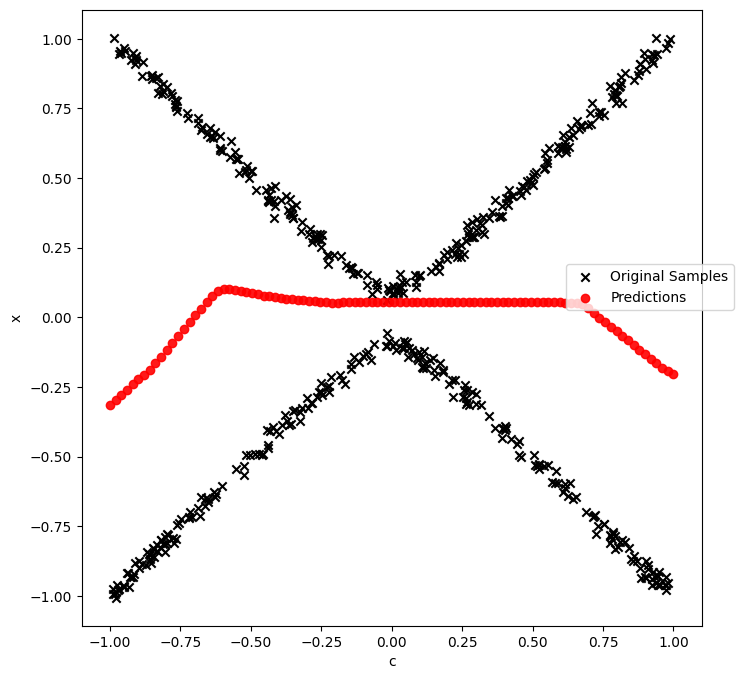


=== Training Run 5 ===
Epoch [1/100], Loss: 0.3703, LR: 0.001000
Epoch [2/100], Loss: 0.3647, LR: 0.001000
Epoch [3/100], Loss: 0.3655, LR: 0.001000
Epoch [4/100], Loss: 0.3649, LR: 0.001000
Epoch [5/100], Loss: 0.3643, LR: 0.001000
Epoch [6/100], Loss: 0.3633, LR: 0.001000
Epoch [7/100], Loss: 0.3592, LR: 0.001000
Epoch [8/100], Loss: 0.3586, LR: 0.001000
Epoch [9/100], Loss: 0.3590, LR: 0.001000
Epoch [10/100], Loss: 0.3626, LR: 0.001000
Epoch [11/100], Loss: 0.3611, LR: 0.001000
Epoch [12/100], Loss: 0.3582, LR: 0.001000
Epoch [13/100], Loss: 0.3556, LR: 0.001000
Epoch [14/100], Loss: 0.3561, LR: 0.001000
Epoch [15/100], Loss: 0.3565, LR: 0.001000
Epoch [16/100], Loss: 0.3574, LR: 0.001000
Epoch [17/100], Loss: 0.3595, LR: 0.001000
Epoch [18/100], Loss: 0.3559, LR: 0.001000
Epoch [19/100], Loss: 0.3628, LR: 0.001000
Epoch [20/100], Loss: 0.3629, LR: 0.000500
Epoch [21/100], Loss: 0.3568, LR: 0.000500
Epoch [22/100], Loss: 0.3556, LR: 0.000500
Epoch [23/100], Loss: 0.3596, LR: 0.000

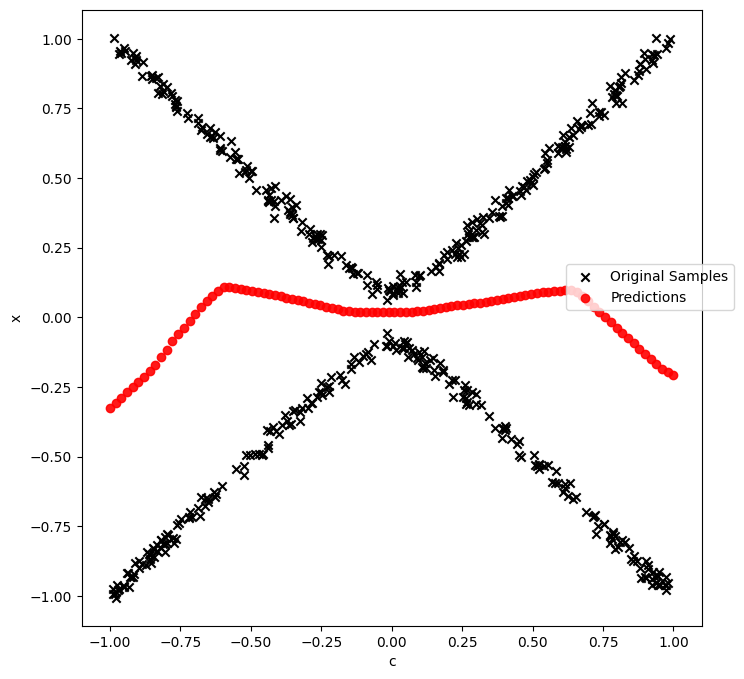

KL Divergence: 14.5423 ± 0.3009
Wasserstein Distance: 0.0281 ± 0.0004
Mode Coverage (%): 0.0000 ± 0.0000
Avgerage Modes coveraged: 0.0320 ± 0.0392


In [21]:
metrics_results = train_and_evaluate_nn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    hidden_size = hidden_size
)

## 2. MDN

In [22]:
# Hyperparameters

hidden_size = 64
num_gaussians = 2
num_epochs = 100
batch_size = 32
learning_rate = 0.001

In [23]:
def visulize_outcomes_mdn(mdn, y_multi, id= 0):
    """
    Visualize the MDN predictions against the true multi-valued function with slightly messy samples.

    Args:
        mdn (torch.nn.Module): Trained MDN model.
        y_multi (function): Multi-valued function generating the true y values.
    """
    # Generate query points and MDN predictions
    num_query_points = 100
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Generate predictions using the MDN
    z = torch.randn(num_query_points, mdn.latent_size).to(device)
    predictions_mdn = mdn.sample(z, query_points_tensor).detach().cpu().numpy()

    # Generate the true function values and add slight noise for "messy" appearance
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))


    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the true functions
    # colors = ['limegreen', 'orange']  # Colors for the two modes
    # for i, (y_val, color) in enumerate(zip(y_vals_transposed, colors)):
    #     ax.plot(x_vals, y_val, color=color, label=f'Target {i+1}: $y_{i+1}(x)$', linewidth=2)
    
    # Plot noisy true samples and generated predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions_mdn, marker='o', color='red', label='Predictions', alpha=0.9)
    
    # Remove grid
    ax.grid(False)
    
    # Set labels and legend
    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.legend(loc='center left', bbox_to_anchor=(0.77, 0.55))
    
    # Show the plot
    plt.savefig(f'images/MDN_G_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [24]:
from methods.mdn import MDNGenerator, train, mdn_loss
def train_and_evaluate_mdn(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate, num_gaussians, hidden_size):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        model = MDNGenerator(input_size, hidden_size, output_size, num_gaussians, condition_size)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        
        # Train
        train(model, dataloader, mdn_loss, optimizer, scheduler, num_epochs, None, device)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics 
        metrics = compute_metrics(model, test_x_vals, true_y_flat , y_multi, model = 'Sampling', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        visulize_outcomes_mdn(model, y_multi, trial)
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results

### Tests


=== Training Run 1 ===
Epoch [1/100], Loss: 0.0436, LR: 0.001000
Epoch [2/100], Loss: 0.0112, LR: 0.001000
Epoch [3/100], Loss: -0.0196, LR: 0.001000
Epoch [4/100], Loss: -0.0489, LR: 0.001000
Epoch [5/100], Loss: -0.0845, LR: 0.001000
Epoch [6/100], Loss: -0.1599, LR: 0.001000
Epoch [7/100], Loss: -0.2863, LR: 0.001000
Epoch [8/100], Loss: -0.5136, LR: 0.001000
Epoch [9/100], Loss: -0.7443, LR: 0.001000
Epoch [10/100], Loss: -0.9623, LR: 0.001000
Epoch [11/100], Loss: -1.4146, LR: 0.001000
Epoch [12/100], Loss: -1.6300, LR: 0.001000
Epoch [13/100], Loss: -1.8342, LR: 0.001000
Epoch [14/100], Loss: -1.8807, LR: 0.001000
Epoch [15/100], Loss: -2.1567, LR: 0.001000
Epoch [16/100], Loss: -2.3197, LR: 0.001000
Epoch [17/100], Loss: -2.2751, LR: 0.001000
Epoch [18/100], Loss: -2.3353, LR: 0.001000
Epoch [19/100], Loss: -2.3994, LR: 0.001000
Epoch [20/100], Loss: -2.3960, LR: 0.000500
Epoch [21/100], Loss: -2.4832, LR: 0.000500
Epoch [22/100], Loss: -2.5246, LR: 0.000500
Epoch [23/100], Los

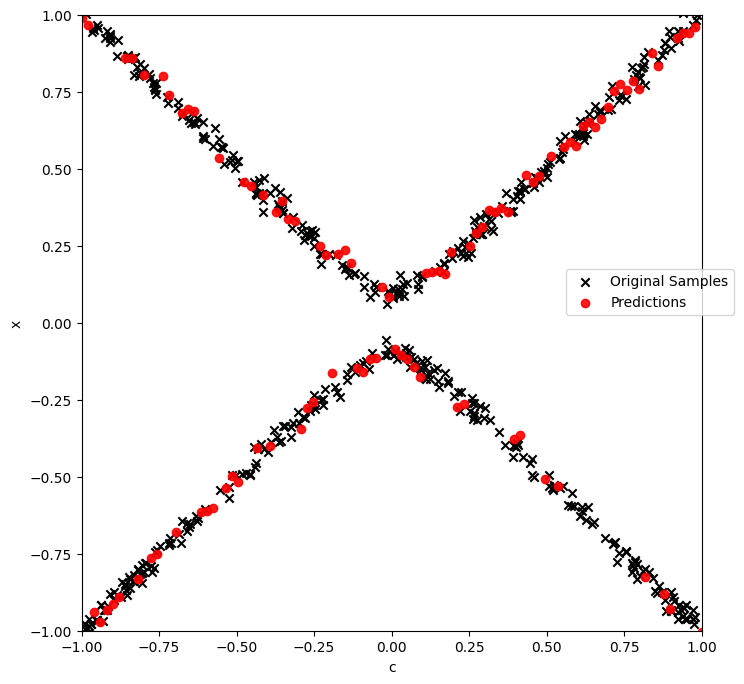


=== Training Run 2 ===
Epoch [1/100], Loss: 0.0903, LR: 0.001000
Epoch [2/100], Loss: 0.0213, LR: 0.001000
Epoch [3/100], Loss: 0.0008, LR: 0.001000
Epoch [4/100], Loss: -0.0145, LR: 0.001000
Epoch [5/100], Loss: -0.0305, LR: 0.001000
Epoch [6/100], Loss: -0.0577, LR: 0.001000
Epoch [7/100], Loss: -0.0947, LR: 0.001000
Epoch [8/100], Loss: -0.1630, LR: 0.001000
Epoch [9/100], Loss: -0.4832, LR: 0.001000
Epoch [10/100], Loss: -1.0421, LR: 0.001000
Epoch [11/100], Loss: -0.6032, LR: 0.001000
Epoch [12/100], Loss: -1.0022, LR: 0.001000
Epoch [13/100], Loss: -1.3272, LR: 0.001000
Epoch [14/100], Loss: -1.7642, LR: 0.001000
Epoch [15/100], Loss: -1.7745, LR: 0.001000
Epoch [16/100], Loss: -1.6339, LR: 0.001000
Epoch [17/100], Loss: -1.8576, LR: 0.001000
Epoch [18/100], Loss: -1.9306, LR: 0.001000
Epoch [19/100], Loss: -2.0466, LR: 0.001000
Epoch [20/100], Loss: -1.9798, LR: 0.000500
Epoch [21/100], Loss: -2.0792, LR: 0.000500
Epoch [22/100], Loss: -2.2007, LR: 0.000500
Epoch [23/100], Loss

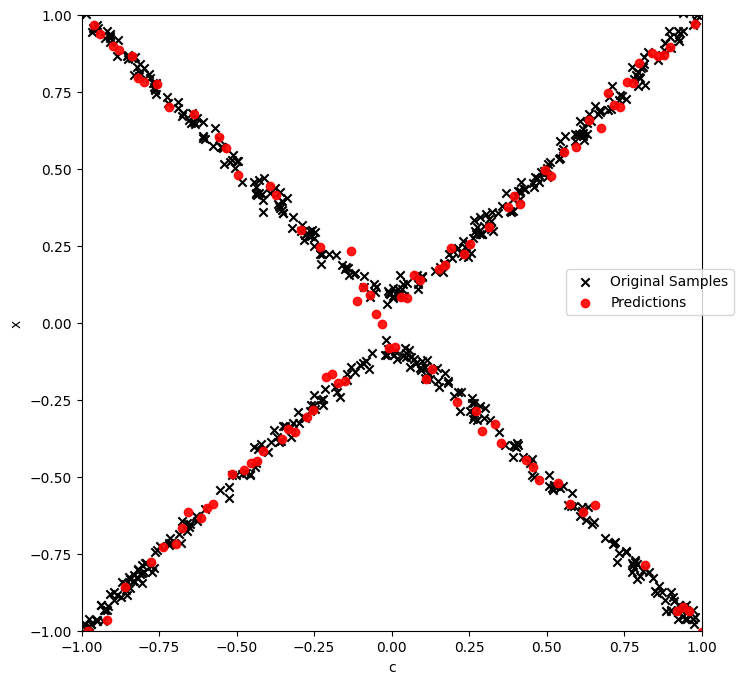


=== Training Run 3 ===
Epoch [1/100], Loss: 0.0473, LR: 0.001000
Epoch [2/100], Loss: -0.0107, LR: 0.001000
Epoch [3/100], Loss: -0.0915, LR: 0.001000
Epoch [4/100], Loss: -0.3046, LR: 0.001000
Epoch [5/100], Loss: -0.6491, LR: 0.001000
Epoch [6/100], Loss: -0.8498, LR: 0.001000
Epoch [7/100], Loss: -0.9739, LR: 0.001000
Epoch [8/100], Loss: -0.4958, LR: 0.001000
Epoch [9/100], Loss: -0.6170, LR: 0.001000
Epoch [10/100], Loss: -0.7834, LR: 0.001000
Epoch [11/100], Loss: -1.0690, LR: 0.001000
Epoch [12/100], Loss: -1.0902, LR: 0.001000
Epoch [13/100], Loss: -1.3146, LR: 0.001000
Epoch [14/100], Loss: -1.4071, LR: 0.001000
Epoch [15/100], Loss: -1.7237, LR: 0.001000
Epoch [16/100], Loss: -1.5331, LR: 0.001000
Epoch [17/100], Loss: -1.6936, LR: 0.001000
Epoch [18/100], Loss: -1.8788, LR: 0.001000
Epoch [19/100], Loss: -2.0162, LR: 0.001000
Epoch [20/100], Loss: -1.9530, LR: 0.000500
Epoch [21/100], Loss: -1.9600, LR: 0.000500
Epoch [22/100], Loss: -2.0685, LR: 0.000500
Epoch [23/100], Lo

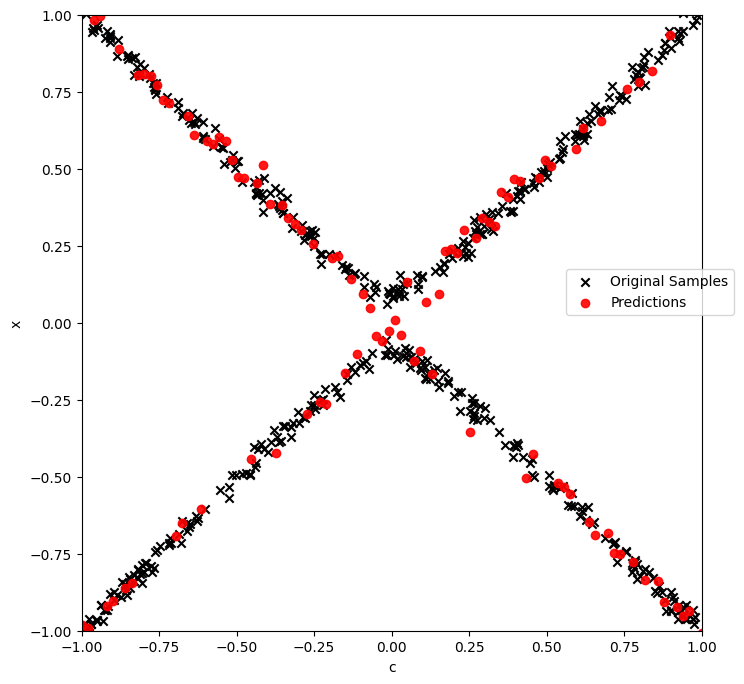


=== Training Run 4 ===
Epoch [1/100], Loss: 0.1001, LR: 0.001000
Epoch [2/100], Loss: 0.0103, LR: 0.001000
Epoch [3/100], Loss: -0.0068, LR: 0.001000
Epoch [4/100], Loss: -0.0312, LR: 0.001000
Epoch [5/100], Loss: -0.0565, LR: 0.001000
Epoch [6/100], Loss: -0.1020, LR: 0.001000
Epoch [7/100], Loss: -0.2243, LR: 0.001000
Epoch [8/100], Loss: -0.5256, LR: 0.001000
Epoch [9/100], Loss: -0.6233, LR: 0.001000
Epoch [10/100], Loss: -0.6988, LR: 0.001000
Epoch [11/100], Loss: -0.8889, LR: 0.001000
Epoch [12/100], Loss: -0.9811, LR: 0.001000
Epoch [13/100], Loss: -0.9935, LR: 0.001000
Epoch [14/100], Loss: -1.0474, LR: 0.001000
Epoch [15/100], Loss: -1.0645, LR: 0.001000
Epoch [16/100], Loss: -1.0459, LR: 0.001000
Epoch [17/100], Loss: -1.1047, LR: 0.001000
Epoch [18/100], Loss: -1.0329, LR: 0.001000
Epoch [19/100], Loss: -1.1905, LR: 0.001000
Epoch [20/100], Loss: -1.2175, LR: 0.000500
Epoch [21/100], Loss: -1.2418, LR: 0.000500
Epoch [22/100], Loss: -1.2589, LR: 0.000500
Epoch [23/100], Los

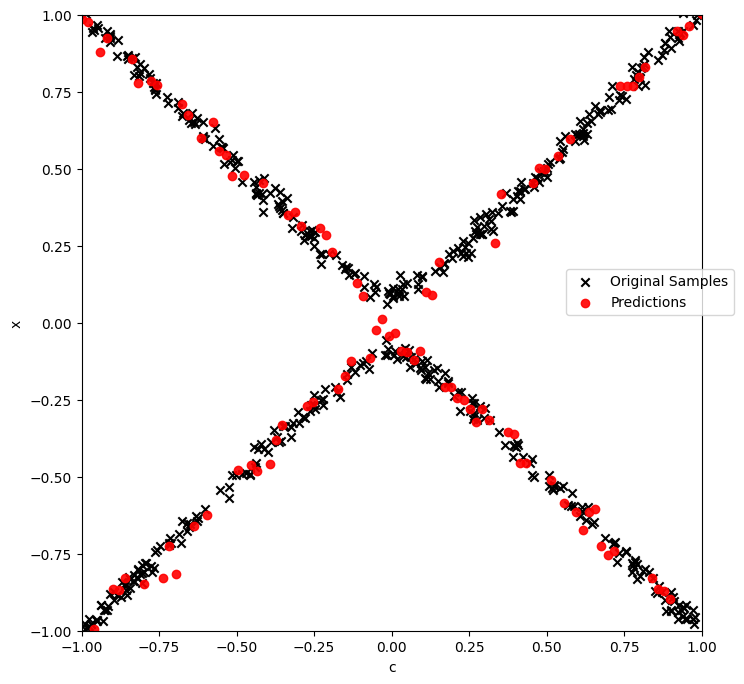


=== Training Run 5 ===
Epoch [1/100], Loss: 0.0870, LR: 0.001000
Epoch [2/100], Loss: 0.0262, LR: 0.001000
Epoch [3/100], Loss: -0.0256, LR: 0.001000
Epoch [4/100], Loss: -0.0981, LR: 0.001000
Epoch [5/100], Loss: -0.2257, LR: 0.001000
Epoch [6/100], Loss: -0.3463, LR: 0.001000
Epoch [7/100], Loss: -0.6091, LR: 0.001000
Epoch [8/100], Loss: -0.8652, LR: 0.001000
Epoch [9/100], Loss: -1.1481, LR: 0.001000
Epoch [10/100], Loss: -1.3299, LR: 0.001000
Epoch [11/100], Loss: -1.6192, LR: 0.001000
Epoch [12/100], Loss: -1.4967, LR: 0.001000
Epoch [13/100], Loss: -1.9074, LR: 0.001000
Epoch [14/100], Loss: -2.1346, LR: 0.001000
Epoch [15/100], Loss: -1.8719, LR: 0.001000
Epoch [16/100], Loss: -2.1765, LR: 0.001000
Epoch [17/100], Loss: -2.3246, LR: 0.001000
Epoch [18/100], Loss: -2.1816, LR: 0.001000
Epoch [19/100], Loss: -2.2622, LR: 0.001000
Epoch [20/100], Loss: -2.1624, LR: 0.000500
Epoch [21/100], Loss: -2.2913, LR: 0.000500
Epoch [22/100], Loss: -2.3874, LR: 0.000500
Epoch [23/100], Los

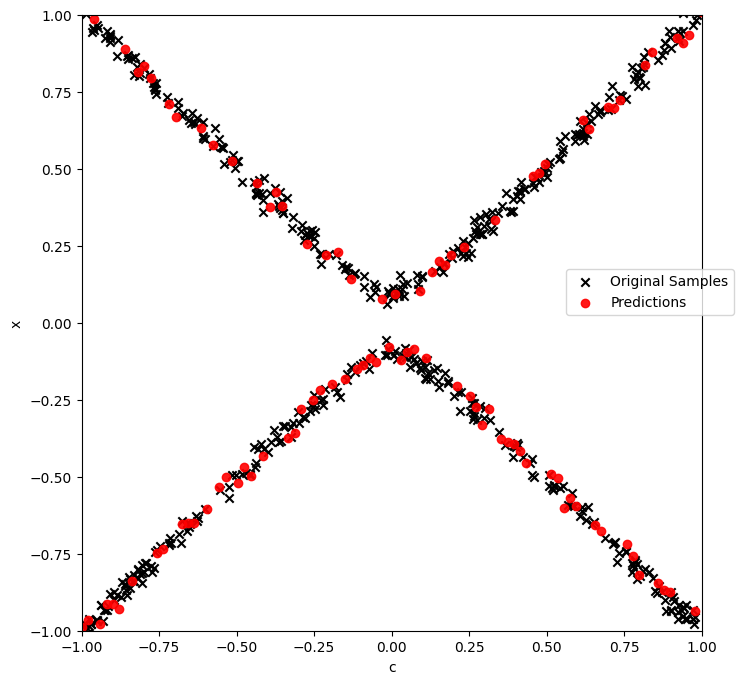

KL Divergence: 2.4057 ± 0.6291
Wasserstein Distance: 0.0080 ± 0.0007
Mode Coverage (%): 98.8000 ± 1.1662
Avgerage Modes coveraged: 1.9880 ± 0.0117


In [25]:
metrics_results = train_and_evaluate_mdn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    num_gaussians = num_gaussians,
    hidden_size = hidden_size
)


=== Training Run 1 ===
Epoch [1/100], Loss: 0.0605, LR: 0.001000
Epoch [2/100], Loss: 0.0234, LR: 0.001000
Epoch [3/100], Loss: -0.0083, LR: 0.001000
Epoch [4/100], Loss: -0.0279, LR: 0.001000
Epoch [5/100], Loss: -0.0568, LR: 0.001000
Epoch [6/100], Loss: -0.0919, LR: 0.001000
Epoch [7/100], Loss: -0.1348, LR: 0.001000
Epoch [8/100], Loss: -0.1743, LR: 0.001000
Epoch [9/100], Loss: -0.2080, LR: 0.001000
Epoch [10/100], Loss: -0.2191, LR: 0.001000
Epoch [11/100], Loss: -0.2399, LR: 0.001000
Epoch [12/100], Loss: -0.2565, LR: 0.001000
Epoch [13/100], Loss: -0.2617, LR: 0.001000
Epoch [14/100], Loss: -0.2623, LR: 0.001000
Epoch [15/100], Loss: -0.2763, LR: 0.001000
Epoch [16/100], Loss: -0.2774, LR: 0.001000
Epoch [17/100], Loss: -0.2649, LR: 0.001000
Epoch [18/100], Loss: -0.2744, LR: 0.001000
Epoch [19/100], Loss: -0.2663, LR: 0.001000
Epoch [20/100], Loss: -0.2822, LR: 0.000500
Epoch [21/100], Loss: -0.2910, LR: 0.000500
Epoch [22/100], Loss: -0.2838, LR: 0.000500
Epoch [23/100], Los

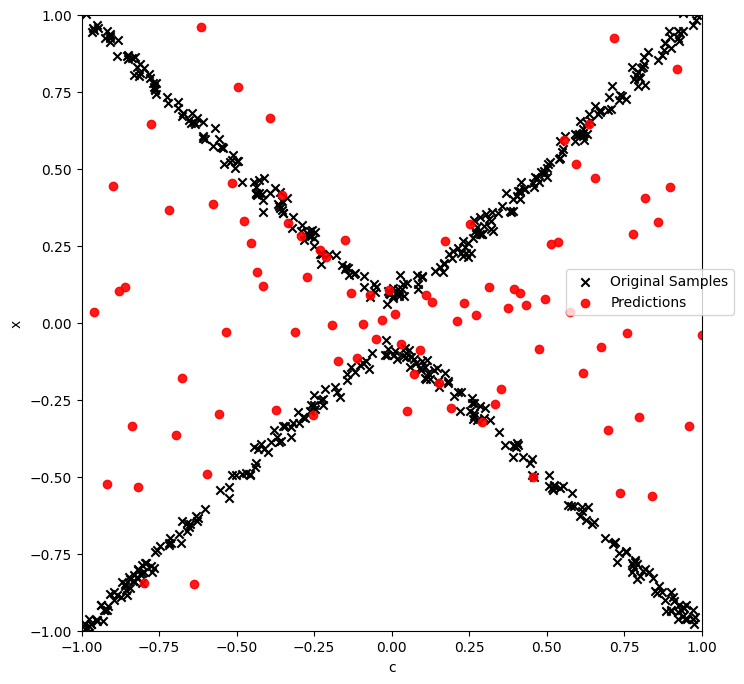


=== Training Run 2 ===
Epoch [1/100], Loss: 0.0969, LR: 0.001000
Epoch [2/100], Loss: 0.0250, LR: 0.001000
Epoch [3/100], Loss: -0.0009, LR: 0.001000
Epoch [4/100], Loss: -0.0251, LR: 0.001000
Epoch [5/100], Loss: -0.0546, LR: 0.001000
Epoch [6/100], Loss: -0.0926, LR: 0.001000
Epoch [7/100], Loss: -0.1390, LR: 0.001000
Epoch [8/100], Loss: -0.1647, LR: 0.001000
Epoch [9/100], Loss: -0.2091, LR: 0.001000
Epoch [10/100], Loss: -0.2335, LR: 0.001000
Epoch [11/100], Loss: -0.2464, LR: 0.001000
Epoch [12/100], Loss: -0.2412, LR: 0.001000
Epoch [13/100], Loss: -0.2515, LR: 0.001000
Epoch [14/100], Loss: -0.2636, LR: 0.001000
Epoch [15/100], Loss: -0.2749, LR: 0.001000
Epoch [16/100], Loss: -0.2713, LR: 0.001000
Epoch [17/100], Loss: -0.2732, LR: 0.001000
Epoch [18/100], Loss: -0.2754, LR: 0.001000
Epoch [19/100], Loss: -0.2867, LR: 0.001000
Epoch [20/100], Loss: -0.2876, LR: 0.000500
Epoch [21/100], Loss: -0.2879, LR: 0.000500
Epoch [22/100], Loss: -0.2873, LR: 0.000500
Epoch [23/100], Los

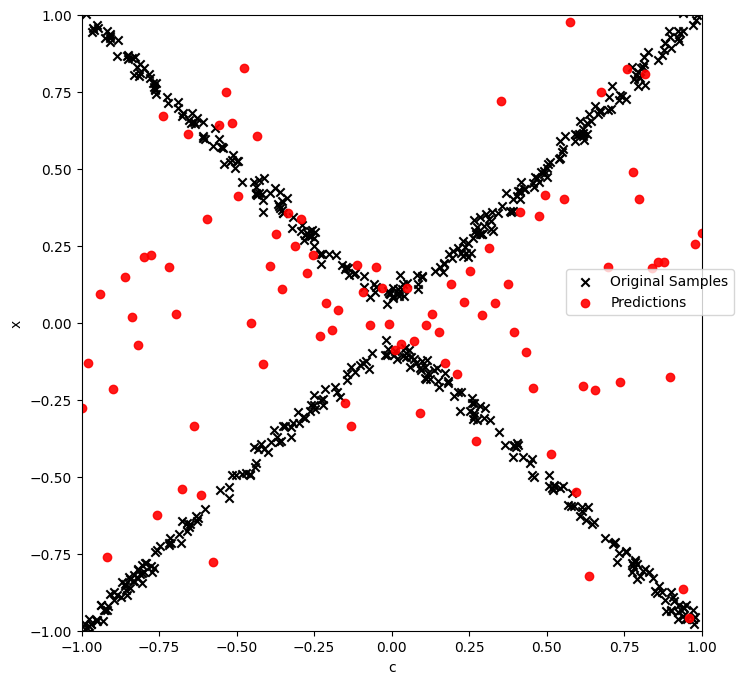


=== Training Run 3 ===
Epoch [1/100], Loss: 0.1179, LR: 0.001000
Epoch [2/100], Loss: 0.0294, LR: 0.001000
Epoch [3/100], Loss: 0.0152, LR: 0.001000
Epoch [4/100], Loss: -0.0143, LR: 0.001000
Epoch [5/100], Loss: -0.0265, LR: 0.001000
Epoch [6/100], Loss: -0.0523, LR: 0.001000
Epoch [7/100], Loss: -0.0693, LR: 0.001000
Epoch [8/100], Loss: -0.0972, LR: 0.001000
Epoch [9/100], Loss: -0.1260, LR: 0.001000
Epoch [10/100], Loss: -0.1716, LR: 0.001000
Epoch [11/100], Loss: -0.2027, LR: 0.001000
Epoch [12/100], Loss: -0.2200, LR: 0.001000
Epoch [13/100], Loss: -0.2529, LR: 0.001000
Epoch [14/100], Loss: -0.2489, LR: 0.001000
Epoch [15/100], Loss: -0.2583, LR: 0.001000
Epoch [16/100], Loss: -0.2663, LR: 0.001000
Epoch [17/100], Loss: -0.2751, LR: 0.001000
Epoch [18/100], Loss: -0.2831, LR: 0.001000
Epoch [19/100], Loss: -0.2697, LR: 0.001000
Epoch [20/100], Loss: -0.2730, LR: 0.000500
Epoch [21/100], Loss: -0.2718, LR: 0.000500
Epoch [22/100], Loss: -0.2819, LR: 0.000500
Epoch [23/100], Loss

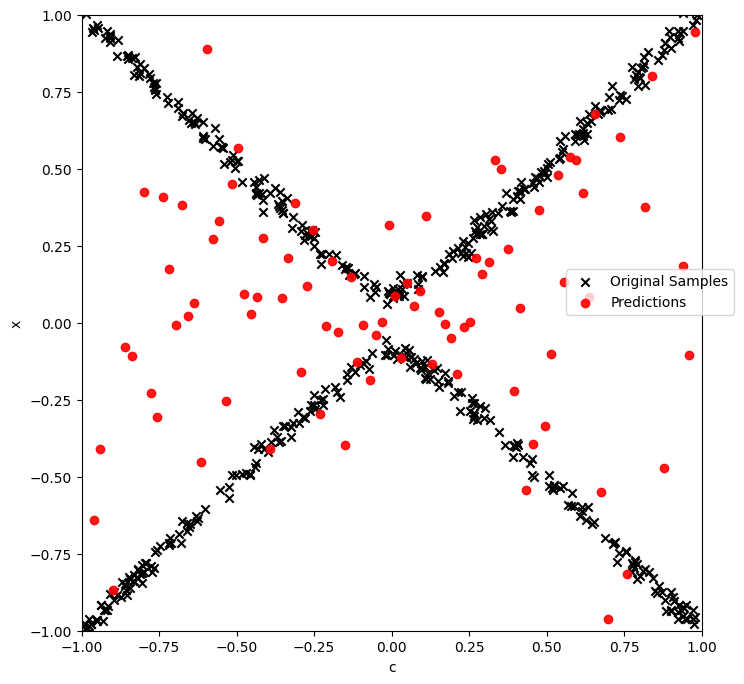


=== Training Run 4 ===
Epoch [1/100], Loss: 0.0718, LR: 0.001000
Epoch [2/100], Loss: 0.0132, LR: 0.001000
Epoch [3/100], Loss: -0.0188, LR: 0.001000
Epoch [4/100], Loss: -0.0479, LR: 0.001000
Epoch [5/100], Loss: -0.0665, LR: 0.001000
Epoch [6/100], Loss: -0.1035, LR: 0.001000
Epoch [7/100], Loss: -0.1407, LR: 0.001000
Epoch [8/100], Loss: -0.1758, LR: 0.001000
Epoch [9/100], Loss: -0.2205, LR: 0.001000
Epoch [10/100], Loss: -0.2467, LR: 0.001000
Epoch [11/100], Loss: -0.2510, LR: 0.001000
Epoch [12/100], Loss: -0.2667, LR: 0.001000
Epoch [13/100], Loss: -0.2702, LR: 0.001000
Epoch [14/100], Loss: -0.2681, LR: 0.001000
Epoch [15/100], Loss: -0.2799, LR: 0.001000
Epoch [16/100], Loss: -0.2796, LR: 0.001000
Epoch [17/100], Loss: -0.2704, LR: 0.001000
Epoch [18/100], Loss: -0.2739, LR: 0.001000
Epoch [19/100], Loss: -0.2884, LR: 0.001000
Epoch [20/100], Loss: -0.2919, LR: 0.000500
Epoch [21/100], Loss: -0.2889, LR: 0.000500
Epoch [22/100], Loss: -0.2942, LR: 0.000500
Epoch [23/100], Los

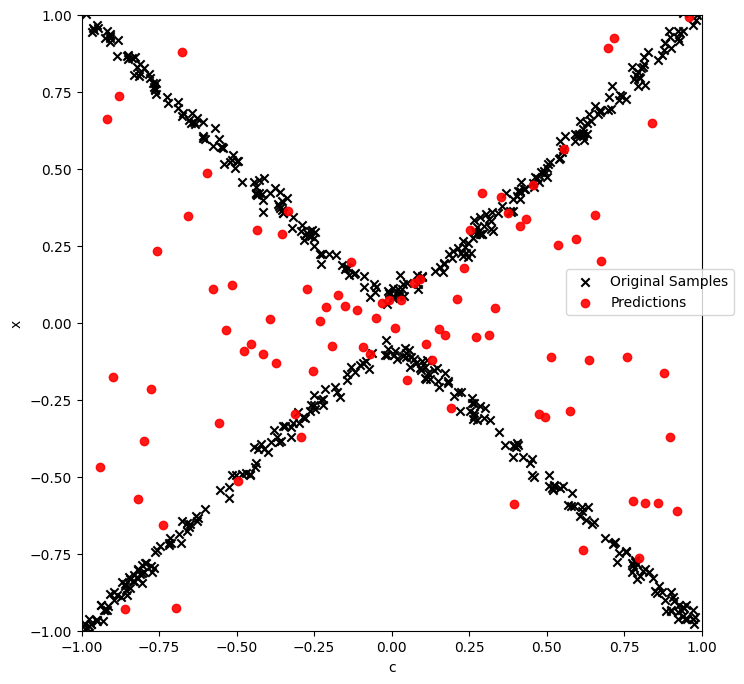


=== Training Run 5 ===
Epoch [1/100], Loss: 0.0395, LR: 0.001000
Epoch [2/100], Loss: 0.0040, LR: 0.001000
Epoch [3/100], Loss: -0.0198, LR: 0.001000
Epoch [4/100], Loss: -0.0328, LR: 0.001000
Epoch [5/100], Loss: -0.0660, LR: 0.001000
Epoch [6/100], Loss: -0.0968, LR: 0.001000
Epoch [7/100], Loss: -0.1503, LR: 0.001000
Epoch [8/100], Loss: -0.1890, LR: 0.001000
Epoch [9/100], Loss: -0.2264, LR: 0.001000
Epoch [10/100], Loss: -0.2473, LR: 0.001000
Epoch [11/100], Loss: -0.2634, LR: 0.001000
Epoch [12/100], Loss: -0.2699, LR: 0.001000
Epoch [13/100], Loss: -0.2786, LR: 0.001000
Epoch [14/100], Loss: -0.2762, LR: 0.001000
Epoch [15/100], Loss: -0.2661, LR: 0.001000
Epoch [16/100], Loss: -0.2711, LR: 0.001000
Epoch [17/100], Loss: -0.2757, LR: 0.001000
Epoch [18/100], Loss: -0.2744, LR: 0.001000
Epoch [19/100], Loss: -0.2823, LR: 0.001000
Epoch [20/100], Loss: -0.2809, LR: 0.000500
Epoch [21/100], Loss: -0.2809, LR: 0.000500
Epoch [22/100], Loss: -0.2836, LR: 0.000500
Epoch [23/100], Los

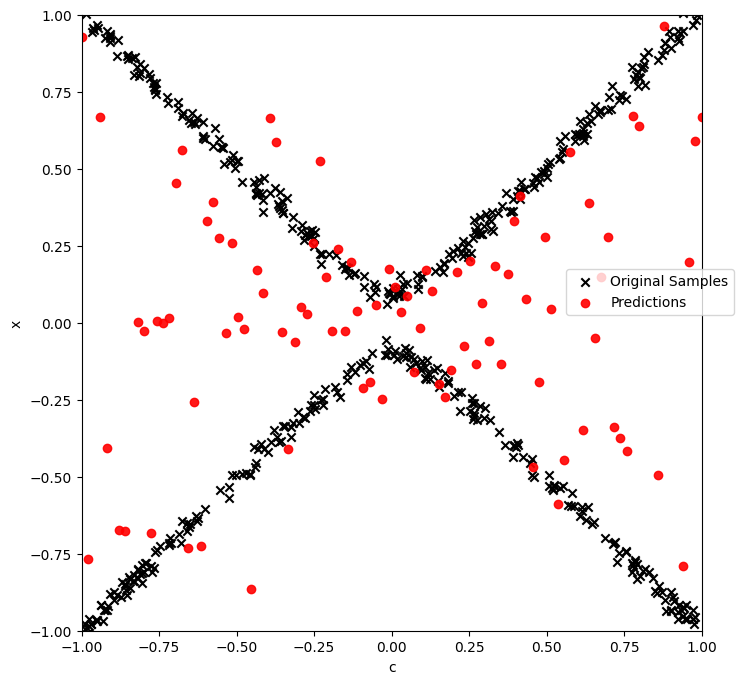

KL Divergence: 5.0400 ± 1.2057
Wasserstein Distance: 0.0128 ± 0.0012
Mode Coverage (%): 32.2000 ± 2.4819
Avgerage Modes coveraged: 1.0880 ± 0.0534


In [26]:
metrics_results = train_and_evaluate_mdn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    num_gaussians = 1,
    hidden_size = hidden_size
)


=== Training Run 1 ===
Epoch [1/100], Loss: 0.1450, LR: 0.001000
Epoch [2/100], Loss: 0.0401, LR: 0.001000
Epoch [3/100], Loss: 0.0202, LR: 0.001000
Epoch [4/100], Loss: -0.0254, LR: 0.001000
Epoch [5/100], Loss: -0.1280, LR: 0.001000
Epoch [6/100], Loss: -0.1760, LR: 0.001000
Epoch [7/100], Loss: -0.3237, LR: 0.001000
Epoch [8/100], Loss: -0.5235, LR: 0.001000
Epoch [9/100], Loss: -0.6815, LR: 0.001000
Epoch [10/100], Loss: -0.8062, LR: 0.001000
Epoch [11/100], Loss: -0.9320, LR: 0.001000
Epoch [12/100], Loss: -0.9058, LR: 0.001000
Epoch [13/100], Loss: -0.9314, LR: 0.001000
Epoch [14/100], Loss: -1.2463, LR: 0.001000
Epoch [15/100], Loss: -1.5788, LR: 0.001000
Epoch [16/100], Loss: -1.5554, LR: 0.001000
Epoch [17/100], Loss: -1.6723, LR: 0.001000
Epoch [18/100], Loss: -1.9399, LR: 0.001000
Epoch [19/100], Loss: -1.9764, LR: 0.001000
Epoch [20/100], Loss: -1.7818, LR: 0.000500
Epoch [21/100], Loss: -2.0196, LR: 0.000500
Epoch [22/100], Loss: -2.1534, LR: 0.000500
Epoch [23/100], Loss

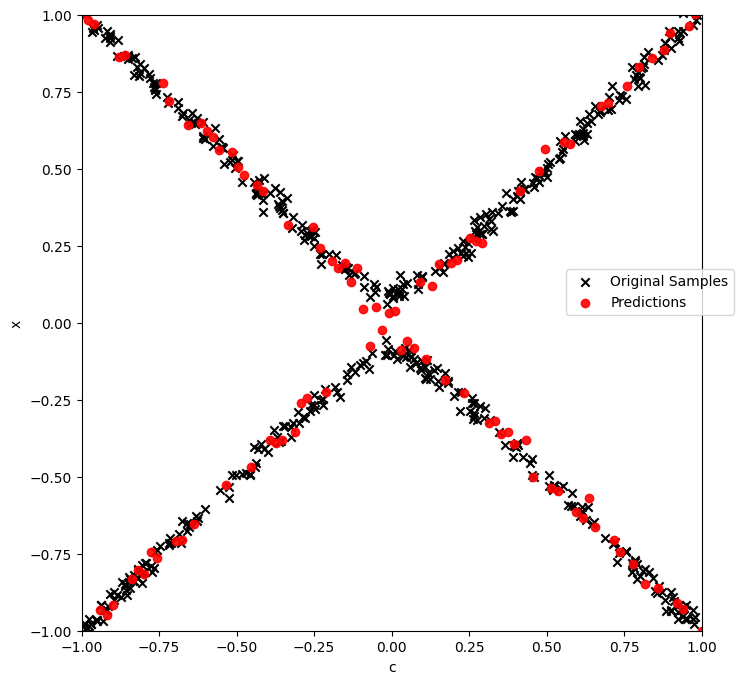


=== Training Run 2 ===
Epoch [1/100], Loss: 0.0971, LR: 0.001000
Epoch [2/100], Loss: 0.0253, LR: 0.001000
Epoch [3/100], Loss: -0.0082, LR: 0.001000
Epoch [4/100], Loss: -0.0208, LR: 0.001000
Epoch [5/100], Loss: -0.0519, LR: 0.001000
Epoch [6/100], Loss: -0.1574, LR: 0.001000
Epoch [7/100], Loss: -0.4505, LR: 0.001000
Epoch [8/100], Loss: -0.6694, LR: 0.001000
Epoch [9/100], Loss: -0.7312, LR: 0.001000
Epoch [10/100], Loss: -0.8418, LR: 0.001000
Epoch [11/100], Loss: -1.1962, LR: 0.001000
Epoch [12/100], Loss: -1.4150, LR: 0.001000
Epoch [13/100], Loss: -1.5363, LR: 0.001000
Epoch [14/100], Loss: -1.5299, LR: 0.001000
Epoch [15/100], Loss: -1.7260, LR: 0.001000
Epoch [16/100], Loss: -1.9044, LR: 0.001000
Epoch [17/100], Loss: -1.9570, LR: 0.001000
Epoch [18/100], Loss: -1.8753, LR: 0.001000
Epoch [19/100], Loss: -2.0039, LR: 0.001000
Epoch [20/100], Loss: -2.1551, LR: 0.000500
Epoch [21/100], Loss: -2.2052, LR: 0.000500
Epoch [22/100], Loss: -2.1743, LR: 0.000500
Epoch [23/100], Los

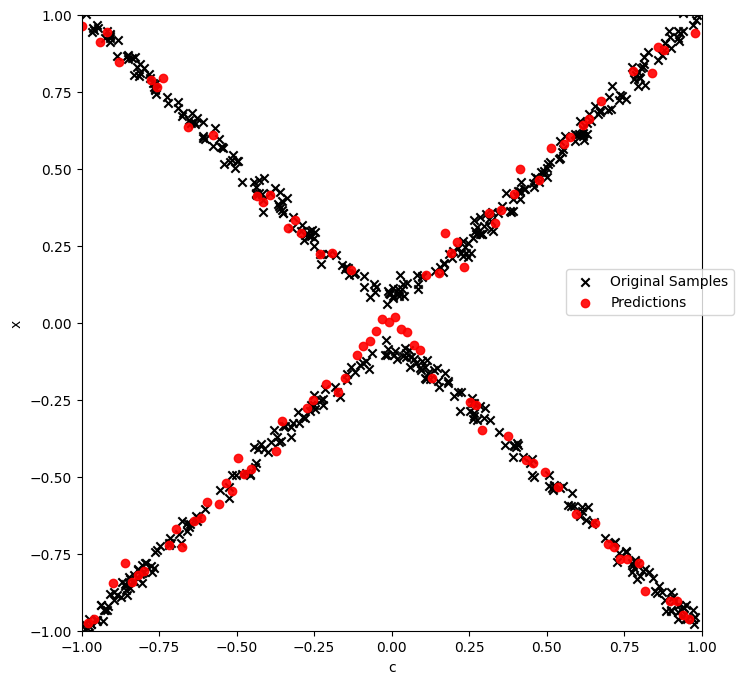


=== Training Run 3 ===
Epoch [1/100], Loss: 0.1204, LR: 0.001000
Epoch [2/100], Loss: 0.0139, LR: 0.001000
Epoch [3/100], Loss: -0.0024, LR: 0.001000
Epoch [4/100], Loss: -0.0228, LR: 0.001000
Epoch [5/100], Loss: -0.0474, LR: 0.001000
Epoch [6/100], Loss: -0.1095, LR: 0.001000
Epoch [7/100], Loss: -0.2467, LR: 0.001000
Epoch [8/100], Loss: -0.5315, LR: 0.001000
Epoch [9/100], Loss: -0.9178, LR: 0.001000
Epoch [10/100], Loss: -1.3623, LR: 0.001000
Epoch [11/100], Loss: -1.5317, LR: 0.001000
Epoch [12/100], Loss: -1.7264, LR: 0.001000
Epoch [13/100], Loss: -1.8514, LR: 0.001000
Epoch [14/100], Loss: -1.9953, LR: 0.001000
Epoch [15/100], Loss: -2.1667, LR: 0.001000
Epoch [16/100], Loss: -2.1105, LR: 0.001000
Epoch [17/100], Loss: -1.9914, LR: 0.001000
Epoch [18/100], Loss: -2.1862, LR: 0.001000
Epoch [19/100], Loss: -2.1360, LR: 0.001000
Epoch [20/100], Loss: -2.2480, LR: 0.000500
Epoch [21/100], Loss: -2.3743, LR: 0.000500
Epoch [22/100], Loss: -2.4140, LR: 0.000500
Epoch [23/100], Los

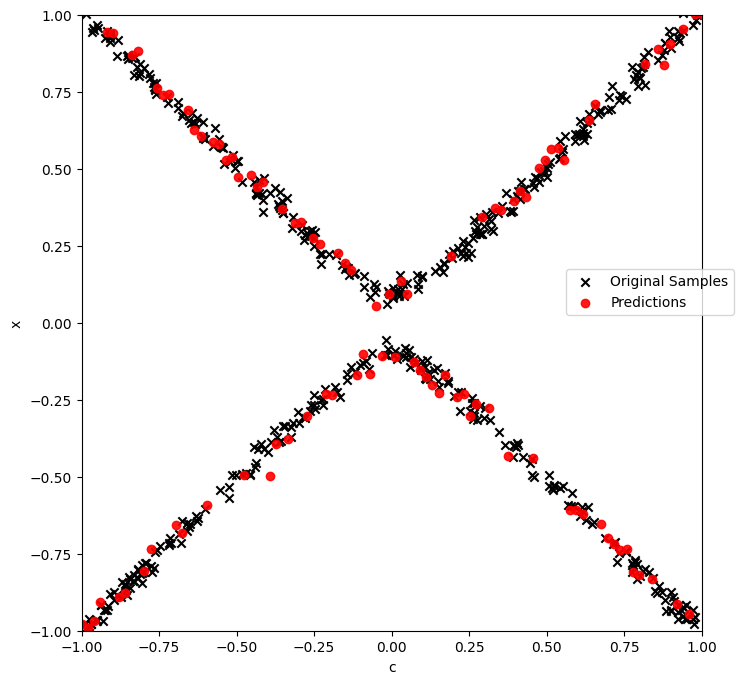


=== Training Run 4 ===
Epoch [1/100], Loss: 0.0951, LR: 0.001000
Epoch [2/100], Loss: 0.0149, LR: 0.001000
Epoch [3/100], Loss: -0.0070, LR: 0.001000
Epoch [4/100], Loss: -0.0177, LR: 0.001000
Epoch [5/100], Loss: -0.0695, LR: 0.001000
Epoch [6/100], Loss: -0.2302, LR: 0.001000
Epoch [7/100], Loss: -0.9851, LR: 0.001000
Epoch [8/100], Loss: -1.3557, LR: 0.001000
Epoch [9/100], Loss: -1.6098, LR: 0.001000
Epoch [10/100], Loss: -1.8758, LR: 0.001000
Epoch [11/100], Loss: -1.9245, LR: 0.001000
Epoch [12/100], Loss: -2.0457, LR: 0.001000
Epoch [13/100], Loss: -1.9208, LR: 0.001000
Epoch [14/100], Loss: -1.9063, LR: 0.001000
Epoch [15/100], Loss: -1.7907, LR: 0.001000
Epoch [16/100], Loss: -2.0101, LR: 0.001000
Epoch [17/100], Loss: -1.9577, LR: 0.001000
Epoch [18/100], Loss: -2.0826, LR: 0.001000
Epoch [19/100], Loss: -2.1971, LR: 0.001000
Epoch [20/100], Loss: -2.0328, LR: 0.000500
Epoch [21/100], Loss: -2.1825, LR: 0.000500
Epoch [22/100], Loss: -2.2112, LR: 0.000500
Epoch [23/100], Los

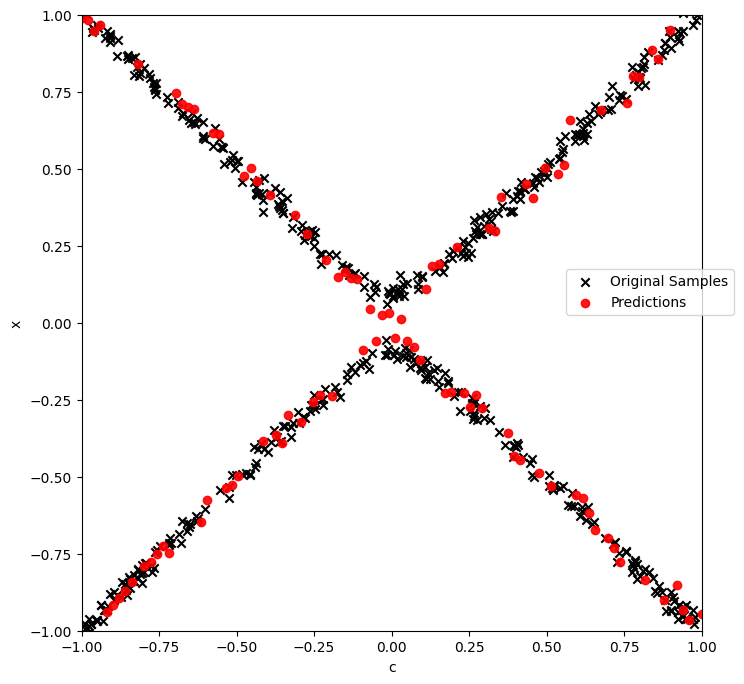


=== Training Run 5 ===
Epoch [1/100], Loss: 0.1013, LR: 0.001000
Epoch [2/100], Loss: 0.0295, LR: 0.001000
Epoch [3/100], Loss: 0.0062, LR: 0.001000
Epoch [4/100], Loss: -0.0147, LR: 0.001000
Epoch [5/100], Loss: -0.0788, LR: 0.001000
Epoch [6/100], Loss: -0.2502, LR: 0.001000
Epoch [7/100], Loss: -0.5268, LR: 0.001000
Epoch [8/100], Loss: -0.7777, LR: 0.001000
Epoch [9/100], Loss: -0.8210, LR: 0.001000
Epoch [10/100], Loss: -0.9991, LR: 0.001000
Epoch [11/100], Loss: -1.0895, LR: 0.001000
Epoch [12/100], Loss: -1.2519, LR: 0.001000
Epoch [13/100], Loss: -1.4994, LR: 0.001000
Epoch [14/100], Loss: -1.4208, LR: 0.001000
Epoch [15/100], Loss: -1.6059, LR: 0.001000
Epoch [16/100], Loss: -1.7424, LR: 0.001000
Epoch [17/100], Loss: -1.7777, LR: 0.001000
Epoch [18/100], Loss: -1.7850, LR: 0.001000
Epoch [19/100], Loss: -1.9755, LR: 0.001000
Epoch [20/100], Loss: -2.1007, LR: 0.000500
Epoch [21/100], Loss: -2.1427, LR: 0.000500
Epoch [22/100], Loss: -2.1749, LR: 0.000500
Epoch [23/100], Loss

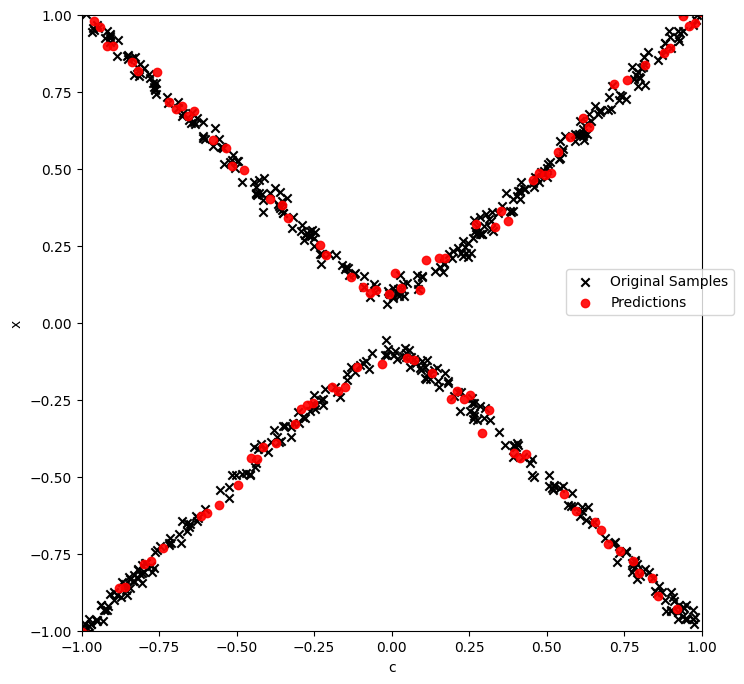

KL Divergence: 1.8261 ± 0.2597
Wasserstein Distance: 0.0067 ± 0.0007
Mode Coverage (%): 99.2000 ± 0.7483
Avgerage Modes coveraged: 1.9920 ± 0.0075


In [27]:
metrics_results = train_and_evaluate_mdn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    num_gaussians = 3,
    hidden_size = hidden_size
)

## 3. cGAN

In [28]:
# Hyperparameters
hidden_size = 64

num_epochs = 100
batch_size = 32
learning_rate = 0.0002

In [29]:
def visulize_outcomes_gan(generator, discriminator, y_multi, id = 0):
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

    # Compute discriminator output for each grid point
    discriminator_outputs = []
    for point in grid_points:
        x_plot = torch.tensor([point[0]], dtype=torch.float32).unsqueeze(0)
        y_plot = torch.tensor([point[1]], dtype=torch.float32).unsqueeze(0)
        output = discriminator(y_plot, x_plot).detach()
        # output = torch.sigmoid(discriminator(y_plot, x_plot)).detach()
        discriminator_outputs.append(output.item())

    # Reshape the outputs to match the grid
    discriminator_outputs = np.array(discriminator_outputs).reshape(100, 100)
    # Normalize every column of the heatmap
    discriminator_outputs = (discriminator_outputs - discriminator_outputs.min(axis=0)) / (discriminator_outputs.max(axis=0) - discriminator_outputs.min(axis=0))

    # As energy, take minus of the discriminator output
    discriminator_outputs = -discriminator_outputs

    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(discriminator_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
    # cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8)
    
    num_query_points = 100
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
    z = torch.randn(num_query_points, generator.latent_size)
    predictions = generator(z, query_points_tensor).detach().numpy()


    # Plot the function
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    for i, y_val in enumerate(y_vals_transposed):
        ax.plot(x_vals, y_val,  linewidth=2)

    # Plot the samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.9)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.grid()
    ax.legend()
    plt.savefig(f'images/cGAN_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
from methods.cgan import Generator, Discriminator, train
def train_and_evaluate_mdn(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate, hidden_size, latent_size):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        # Initialize models
        generator = Generator(latent_size, hidden_size, output_size, condition_size)
        discriminator = Discriminator(output_size, hidden_size, 1, condition_size)

        # Optimizers
        optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
        optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)
        
        # Train
        train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs, writer = None)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics 
        metrics = compute_metrics(generator, test_x_vals, true_y_flat , y_multi, model = 'Generator', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        visulize_outcomes_gan(generator, discriminator, y_multi, trial)
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results

### Tests


=== Training Run 1 ===
Epoch [1/100], Discriminator Loss: 0.9925, Generator Loss: 0.9499
Epoch [2/100], Discriminator Loss: 0.5721, Generator Loss: 1.6492
Epoch [3/100], Discriminator Loss: 0.6091, Generator Loss: 2.7757
Epoch [4/100], Discriminator Loss: 0.6762, Generator Loss: 2.5189
Epoch [5/100], Discriminator Loss: 0.8044, Generator Loss: 1.9475
Epoch [6/100], Discriminator Loss: 0.9097, Generator Loss: 1.4102
Epoch [7/100], Discriminator Loss: 0.9082, Generator Loss: 1.7514
Epoch [8/100], Discriminator Loss: 1.1229, Generator Loss: 1.5902
Epoch [9/100], Discriminator Loss: 0.8438, Generator Loss: 1.3821
Epoch [10/100], Discriminator Loss: 0.8211, Generator Loss: 1.3279
Epoch [11/100], Discriminator Loss: 0.7123, Generator Loss: 1.8116
Epoch [12/100], Discriminator Loss: 0.9780, Generator Loss: 2.4883
Epoch [13/100], Discriminator Loss: 0.5886, Generator Loss: 2.1572
Epoch [14/100], Discriminator Loss: 0.6850, Generator Loss: 2.8692
Epoch [15/100], Discriminator Loss: 0.7765, Gen

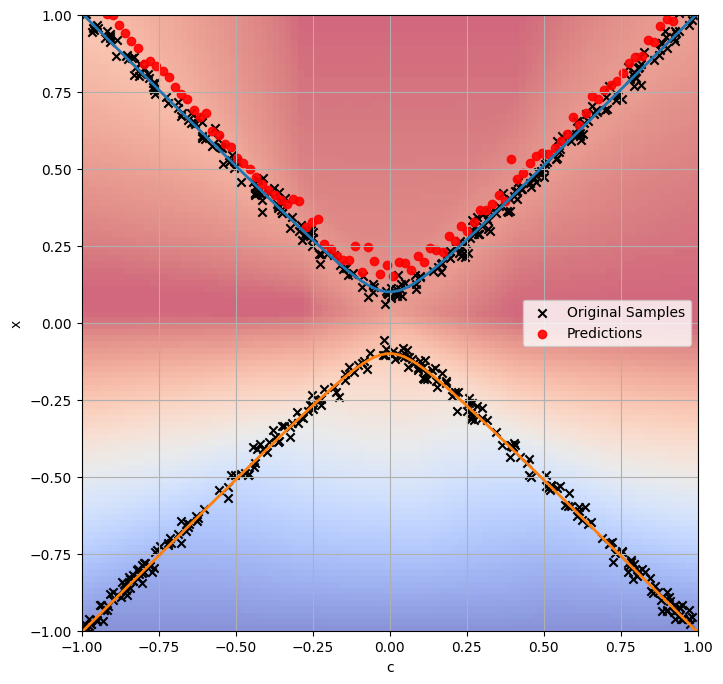


=== Training Run 2 ===
Epoch [1/100], Discriminator Loss: 0.9382, Generator Loss: 0.9752
Epoch [2/100], Discriminator Loss: 0.6058, Generator Loss: 1.5083
Epoch [3/100], Discriminator Loss: 0.9798, Generator Loss: 2.1310
Epoch [4/100], Discriminator Loss: 0.7615, Generator Loss: 1.1913
Epoch [5/100], Discriminator Loss: 1.3921, Generator Loss: 1.2816
Epoch [6/100], Discriminator Loss: 1.0555, Generator Loss: 1.6533
Epoch [7/100], Discriminator Loss: 1.1012, Generator Loss: 1.4463
Epoch [8/100], Discriminator Loss: 0.7820, Generator Loss: 1.5824
Epoch [9/100], Discriminator Loss: 0.8715, Generator Loss: 1.4366
Epoch [10/100], Discriminator Loss: 0.7000, Generator Loss: 1.2863
Epoch [11/100], Discriminator Loss: 0.8067, Generator Loss: 1.5544
Epoch [12/100], Discriminator Loss: 0.6308, Generator Loss: 1.6353
Epoch [13/100], Discriminator Loss: 0.8761, Generator Loss: 1.7332
Epoch [14/100], Discriminator Loss: 0.5490, Generator Loss: 1.8062
Epoch [15/100], Discriminator Loss: 0.4902, Gen

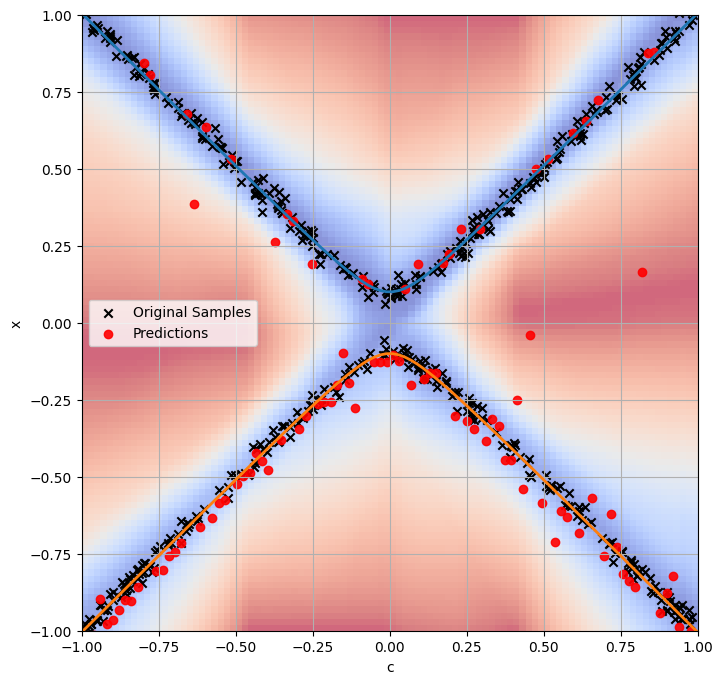


=== Training Run 3 ===
Epoch [1/100], Discriminator Loss: 1.0597, Generator Loss: 0.9004
Epoch [2/100], Discriminator Loss: 0.7069, Generator Loss: 1.3460
Epoch [3/100], Discriminator Loss: 0.7011, Generator Loss: 1.6592
Epoch [4/100], Discriminator Loss: 1.0508, Generator Loss: 1.5154
Epoch [5/100], Discriminator Loss: 1.1545, Generator Loss: 1.8943
Epoch [6/100], Discriminator Loss: 0.8877, Generator Loss: 1.5886
Epoch [7/100], Discriminator Loss: 0.8981, Generator Loss: 1.3246
Epoch [8/100], Discriminator Loss: 0.7478, Generator Loss: 1.8629
Epoch [9/100], Discriminator Loss: 0.9433, Generator Loss: 1.7565
Epoch [10/100], Discriminator Loss: 0.8533, Generator Loss: 1.4932
Epoch [11/100], Discriminator Loss: 0.8351, Generator Loss: 2.2882
Epoch [12/100], Discriminator Loss: 0.7442, Generator Loss: 1.8953
Epoch [13/100], Discriminator Loss: 0.9711, Generator Loss: 2.3654
Epoch [14/100], Discriminator Loss: 0.9352, Generator Loss: 2.1739
Epoch [15/100], Discriminator Loss: 0.6558, Gen

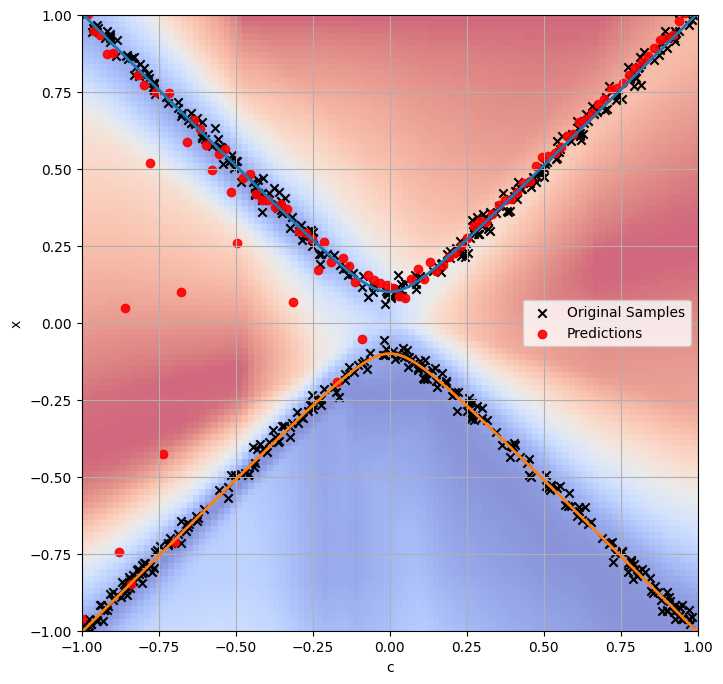


=== Training Run 4 ===
Epoch [1/100], Discriminator Loss: 0.8356, Generator Loss: 1.0910
Epoch [2/100], Discriminator Loss: 0.6904, Generator Loss: 1.3913
Epoch [3/100], Discriminator Loss: 1.4264, Generator Loss: 1.4521
Epoch [4/100], Discriminator Loss: 0.9394, Generator Loss: 1.6978
Epoch [5/100], Discriminator Loss: 1.0747, Generator Loss: 1.0308
Epoch [6/100], Discriminator Loss: 0.8853, Generator Loss: 1.2661
Epoch [7/100], Discriminator Loss: 0.9551, Generator Loss: 1.0334
Epoch [8/100], Discriminator Loss: 1.1128, Generator Loss: 1.9283
Epoch [9/100], Discriminator Loss: 0.8091, Generator Loss: 1.6683
Epoch [10/100], Discriminator Loss: 0.8498, Generator Loss: 1.9238
Epoch [11/100], Discriminator Loss: 0.6486, Generator Loss: 1.8215
Epoch [12/100], Discriminator Loss: 0.6043, Generator Loss: 1.8922
Epoch [13/100], Discriminator Loss: 0.8050, Generator Loss: 1.5330
Epoch [14/100], Discriminator Loss: 0.7458, Generator Loss: 1.9918
Epoch [15/100], Discriminator Loss: 0.6499, Gen

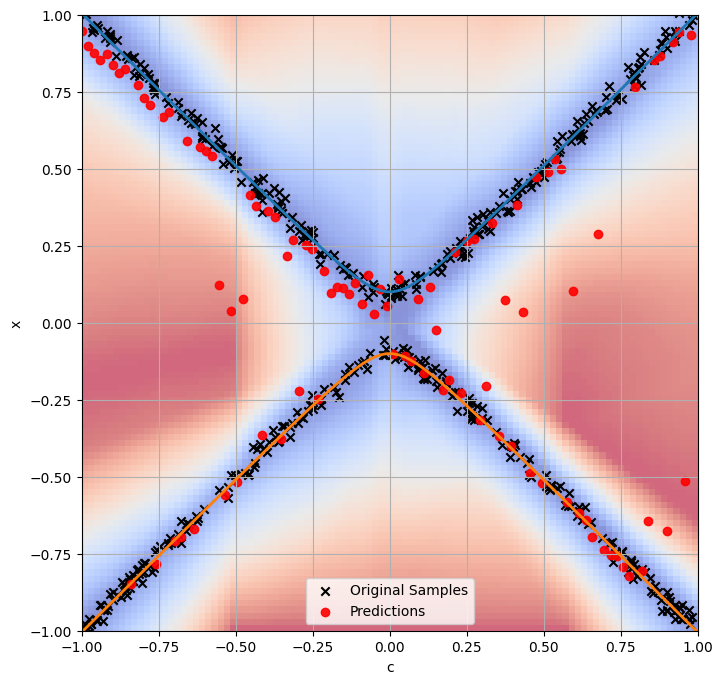


=== Training Run 5 ===
Epoch [1/100], Discriminator Loss: 1.0503, Generator Loss: 0.9055
Epoch [2/100], Discriminator Loss: 0.6392, Generator Loss: 1.5110
Epoch [3/100], Discriminator Loss: 0.9055, Generator Loss: 1.4140
Epoch [4/100], Discriminator Loss: 1.4417, Generator Loss: 0.9461
Epoch [5/100], Discriminator Loss: 1.2058, Generator Loss: 1.2906
Epoch [6/100], Discriminator Loss: 1.0541, Generator Loss: 1.2907
Epoch [7/100], Discriminator Loss: 0.8440, Generator Loss: 1.5387
Epoch [8/100], Discriminator Loss: 0.8376, Generator Loss: 1.3702
Epoch [9/100], Discriminator Loss: 0.6297, Generator Loss: 2.0317
Epoch [10/100], Discriminator Loss: 0.6939, Generator Loss: 1.8751
Epoch [11/100], Discriminator Loss: 0.7687, Generator Loss: 2.0128
Epoch [12/100], Discriminator Loss: 0.5691, Generator Loss: 1.6618
Epoch [13/100], Discriminator Loss: 0.8690, Generator Loss: 2.0826
Epoch [14/100], Discriminator Loss: 0.5617, Generator Loss: 2.6964
Epoch [15/100], Discriminator Loss: 0.3914, Gen

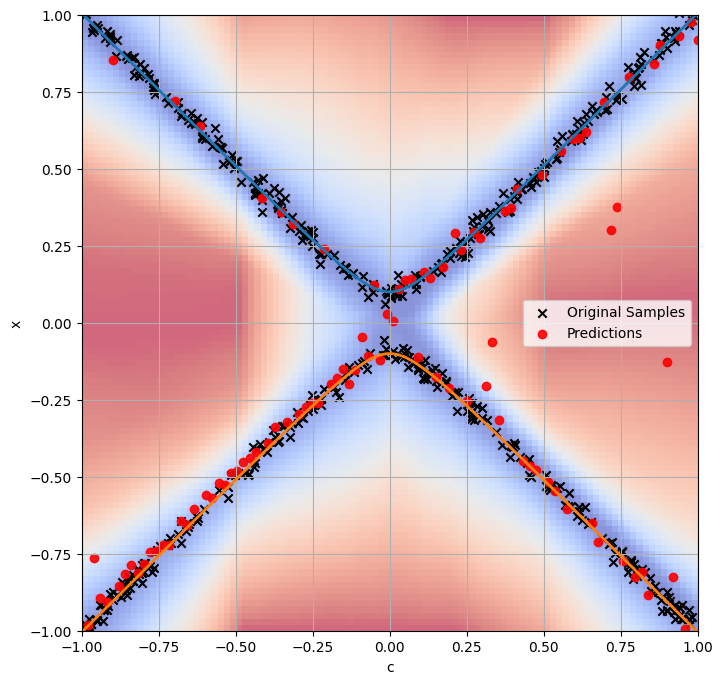

KL Divergence: 4.6726 ± 2.5214
Wasserstein Distance: 0.0119 ± 0.0042
Mode Coverage (%): 65.0000 ± 37.6404
Avgerage Modes coveraged: 1.6420 ± 0.3903


In [31]:
metrics_results = train_and_evaluate_mdn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    hidden_size = hidden_size,
    latent_size = input_size
)

## 4. EBGAN

In [40]:
hidden_size = 64

num_epochs = 100
batch_size = 32
neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

In [41]:
def visualize_outcome_ebgan(generator, energy_model, y_multi, device, epoch = None, save_path="visualizations", num_query_points = 100, id = 0):
    # Random sample the query points and get the predictions
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)

    predictions = []
    for point in query_points:
        query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
        z = torch.randn(1, generator.latent_size, device=device) 
        prediction = generator(z, query_points_tensor).detach().cpu().numpy()
        predictions.append(prediction.item())


    # Visualize the energy model output heatmap
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    # energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))
    # Normalize everything of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min()) / (energy_outputs.max() - energy_outputs.min())


    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
    # plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

    # Plot the function
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    # for i, y_val in enumerate(y_vals_transposed):
    #     ax.plot(x_vals, y_val, linewidth=2)

    # Plot the samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.9)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.grid()
    ax.legend()
    # if epoch: 
    #     ax.set_title(f'Energy-Based Model Predictions in Epoch: {epoch + 1}')
    # else: 
    #     ax.set_title('Energy-Based Model Predictions')
    # plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
    plt.savefig(f'images/EBGAN{id}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [42]:
from methods.ebgan import Generator, EnergyModel, train
def train_and_evaluate_ebgan(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate_g, learning_rate_e, hidden_size):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        # Device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create models
        generator = Generator(input_size, hidden_size, action_size, condition_size).to(device)
        energy_model = EnergyModel(condition_size, action_size, hidden_size).to(device)

        # Setup optimizers
        optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
        optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
        scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)
        scheduler_g = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)
        
        # Train
        train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, scheduler_g,
            num_epochs, None, y_min.to(device), y_max.to(device), neg_count, 
            repeat_energy_updates, device
            )

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics 
        metrics = compute_metrics(generator, test_x_vals, true_y_flat , y_multi, model =  'Generator', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        visualize_outcome_ebgan(generator, energy_model, y_multi, device, num_epochs, save_path="visualizations", id = trial)
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results


=== Training Run 1 ===
Epoch [1/100], Energy Loss: 3.4791, Generator Loss: 0.0165
Epoch [2/100], Energy Loss: 3.2731, Generator Loss: 0.2655
Epoch [3/100], Energy Loss: 2.9384, Generator Loss: 0.9886
Epoch [4/100], Energy Loss: 2.6940, Generator Loss: 1.5436
Epoch [5/100], Energy Loss: 2.4908, Generator Loss: 1.7733
Epoch [6/100], Energy Loss: 2.3801, Generator Loss: 1.4392
Epoch [7/100], Energy Loss: 2.2812, Generator Loss: 1.7011
Epoch [8/100], Energy Loss: 2.2270, Generator Loss: 1.7674
Epoch [9/100], Energy Loss: 2.1799, Generator Loss: 1.9382
Epoch [10/100], Energy Loss: 2.1250, Generator Loss: 2.1094
Epoch [11/100], Energy Loss: 2.1221, Generator Loss: 2.3426
Epoch [12/100], Energy Loss: 2.0564, Generator Loss: 2.5586
Epoch [13/100], Energy Loss: 2.0280, Generator Loss: 2.8316
Epoch [14/100], Energy Loss: 2.0141, Generator Loss: 3.0550
Epoch [15/100], Energy Loss: 1.9523, Generator Loss: 3.2734
Epoch [16/100], Energy Loss: 1.9606, Generator Loss: 3.2366
Epoch [17/100], Energy Lo

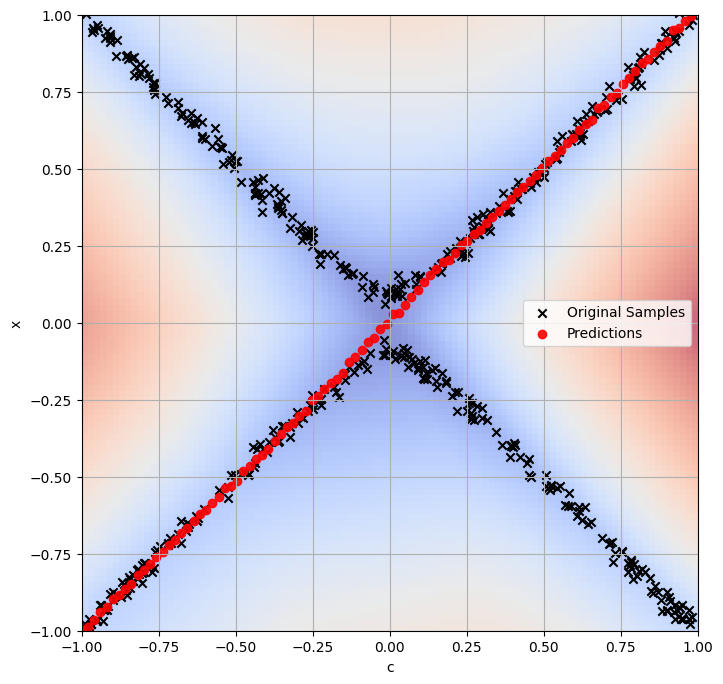


=== Training Run 2 ===
Epoch [1/100], Energy Loss: 3.5075, Generator Loss: 0.1207
Epoch [2/100], Energy Loss: 3.3877, Generator Loss: 0.0934
Epoch [3/100], Energy Loss: 3.0672, Generator Loss: 0.0817
Epoch [4/100], Energy Loss: 2.6966, Generator Loss: 0.3373
Epoch [5/100], Energy Loss: 2.5256, Generator Loss: 0.5507
Epoch [6/100], Energy Loss: 2.3619, Generator Loss: 0.6587
Epoch [7/100], Energy Loss: 2.2774, Generator Loss: 0.6402
Epoch [8/100], Energy Loss: 2.1804, Generator Loss: 0.3657
Epoch [9/100], Energy Loss: 2.1689, Generator Loss: 0.1791
Epoch [10/100], Energy Loss: 2.0594, Generator Loss: 0.2216
Epoch [11/100], Energy Loss: 2.0651, Generator Loss: 0.2357
Epoch [12/100], Energy Loss: 2.0454, Generator Loss: 0.3954
Epoch [13/100], Energy Loss: 2.0282, Generator Loss: 0.4968
Epoch [14/100], Energy Loss: 1.9894, Generator Loss: 0.7393
Epoch [15/100], Energy Loss: 1.9469, Generator Loss: 0.9418
Epoch [16/100], Energy Loss: 1.9331, Generator Loss: 0.9087
Epoch [17/100], Energy Lo

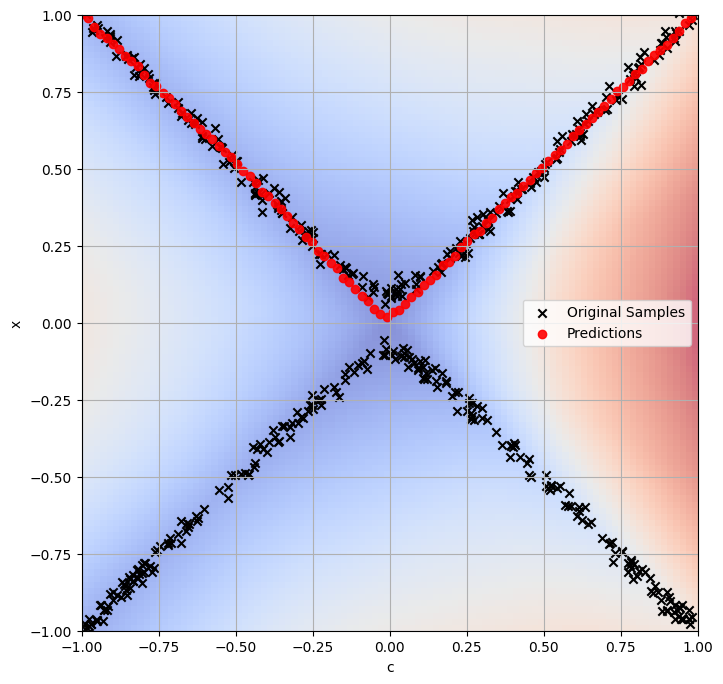


=== Training Run 3 ===
Epoch [1/100], Energy Loss: 3.4832, Generator Loss: 0.0233
Epoch [2/100], Energy Loss: 3.3189, Generator Loss: -0.0198
Epoch [3/100], Energy Loss: 3.0101, Generator Loss: -0.2156
Epoch [4/100], Energy Loss: 2.7450, Generator Loss: -0.5704
Epoch [5/100], Energy Loss: 2.5051, Generator Loss: -1.3324
Epoch [6/100], Energy Loss: 2.4131, Generator Loss: -1.9426
Epoch [7/100], Energy Loss: 2.2698, Generator Loss: -2.5215
Epoch [8/100], Energy Loss: 2.2180, Generator Loss: -3.0551
Epoch [9/100], Energy Loss: 2.1765, Generator Loss: -3.1034
Epoch [10/100], Energy Loss: 2.1227, Generator Loss: -3.1560
Epoch [11/100], Energy Loss: 2.0922, Generator Loss: -2.9710
Epoch [12/100], Energy Loss: 2.0474, Generator Loss: -3.0031
Epoch [13/100], Energy Loss: 2.0072, Generator Loss: -3.1094
Epoch [14/100], Energy Loss: 1.9672, Generator Loss: -3.2441
Epoch [15/100], Energy Loss: 1.9480, Generator Loss: -3.2394
Epoch [16/100], Energy Loss: 1.9782, Generator Loss: -2.9840
Epoch [17/

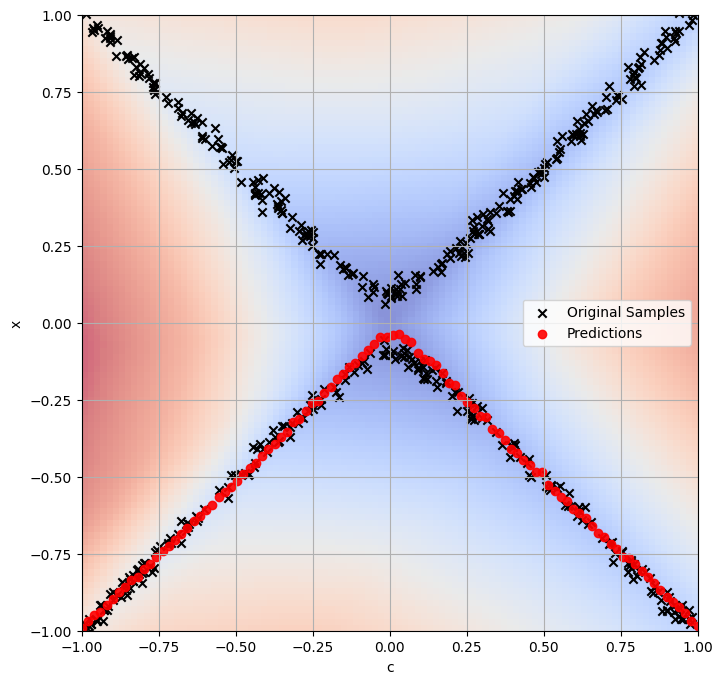


=== Training Run 4 ===
Epoch [1/100], Energy Loss: 3.4959, Generator Loss: -0.0721
Epoch [2/100], Energy Loss: 3.3419, Generator Loss: 0.0634
Epoch [3/100], Energy Loss: 3.0428, Generator Loss: 0.4124
Epoch [4/100], Energy Loss: 2.7620, Generator Loss: 0.8643
Epoch [5/100], Energy Loss: 2.5615, Generator Loss: 1.2298
Epoch [6/100], Energy Loss: 2.3717, Generator Loss: 1.6259
Epoch [7/100], Energy Loss: 2.2713, Generator Loss: 1.5992
Epoch [8/100], Energy Loss: 2.1844, Generator Loss: 1.3654
Epoch [9/100], Energy Loss: 2.1679, Generator Loss: 1.2333
Epoch [10/100], Energy Loss: 2.1314, Generator Loss: 1.2636
Epoch [11/100], Energy Loss: 2.0874, Generator Loss: 1.5147
Epoch [12/100], Energy Loss: 2.0521, Generator Loss: 1.5536
Epoch [13/100], Energy Loss: 2.0486, Generator Loss: 1.6403
Epoch [14/100], Energy Loss: 1.9801, Generator Loss: 1.7426
Epoch [15/100], Energy Loss: 1.9728, Generator Loss: 1.8202
Epoch [16/100], Energy Loss: 1.9594, Generator Loss: 1.9064
Epoch [17/100], Energy L

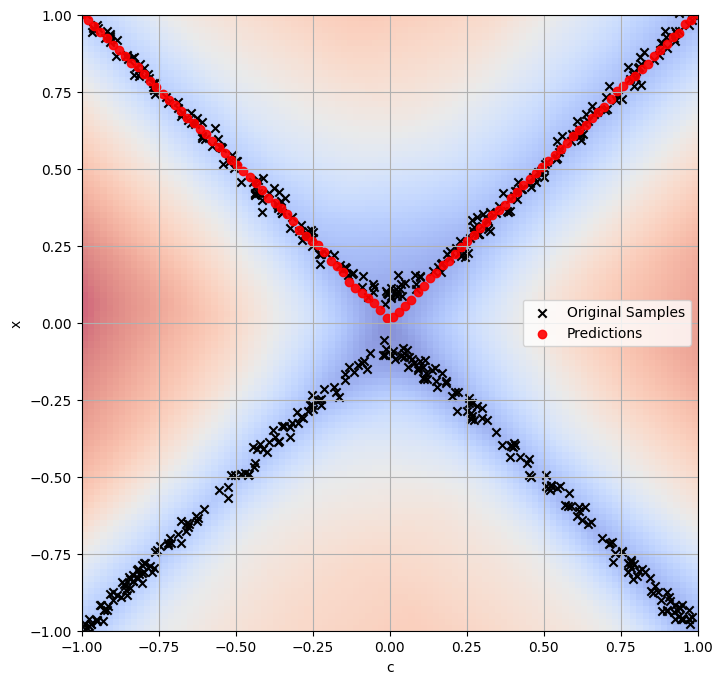


=== Training Run 5 ===
Epoch [1/100], Energy Loss: 3.4855, Generator Loss: 0.0300
Epoch [2/100], Energy Loss: 3.2886, Generator Loss: 0.0811
Epoch [3/100], Energy Loss: 2.9377, Generator Loss: 0.2268
Epoch [4/100], Energy Loss: 2.6560, Generator Loss: 0.1125
Epoch [5/100], Energy Loss: 2.4477, Generator Loss: -0.0832
Epoch [6/100], Energy Loss: 2.3333, Generator Loss: -0.5025
Epoch [7/100], Energy Loss: 2.2649, Generator Loss: -0.7413
Epoch [8/100], Energy Loss: 2.1806, Generator Loss: -0.8818
Epoch [9/100], Energy Loss: 2.1184, Generator Loss: -0.7873
Epoch [10/100], Energy Loss: 2.0409, Generator Loss: -0.6731
Epoch [11/100], Energy Loss: 2.0670, Generator Loss: -0.6811
Epoch [12/100], Energy Loss: 2.0102, Generator Loss: -0.5541
Epoch [13/100], Energy Loss: 1.9659, Generator Loss: -0.4297
Epoch [14/100], Energy Loss: 2.0214, Generator Loss: -0.2537
Epoch [15/100], Energy Loss: 1.9449, Generator Loss: -0.2013
Epoch [16/100], Energy Loss: 1.8935, Generator Loss: -0.2179
Epoch [17/100

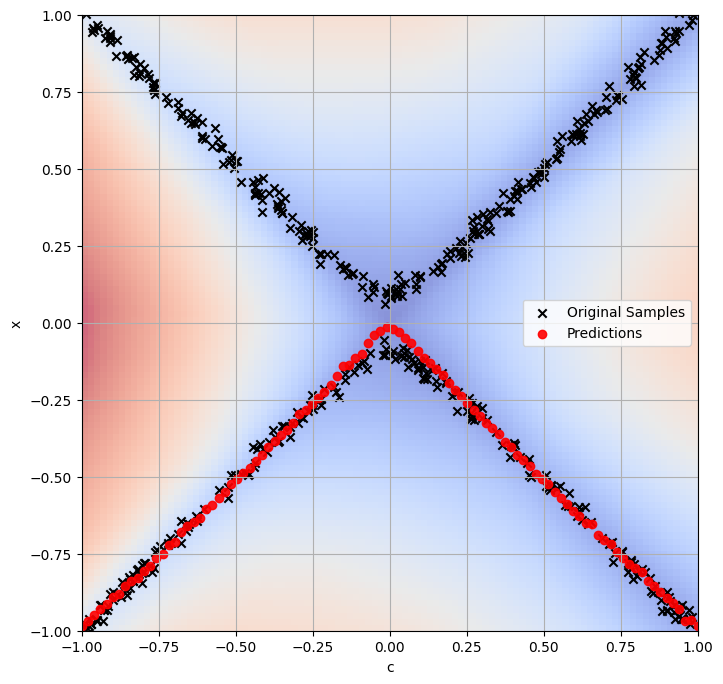

KL Divergence: 6.9242 ± 3.4012
Wasserstein Distance: 0.0140 ± 0.0060
Mode Coverage (%): 0.0000 ± 0.0000
Avgerage Modes coveraged: 0.9900 ± 0.0089


In [43]:
metrics_results = train_and_evaluate_ebgan(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate_g = learning_rate_g,
    learning_rate_e = learning_rate_e,
    hidden_size = hidden_size
)

## 5. IBC

In [44]:
# Hyperparameter

hidden_size = 64
num_epochs = 100
batch_size = 32
neg_count = 64
learning_rate = 0.001

In [45]:
def evaluate_model_ibc(energy_model, ebm_infer, id = 0):
    # Random sample the query points and get the predictions
    num_query_points = 100
    query_points = np.linspace(-1, 1, num_query_points)

    predictions = []
    for point in query_points:
        query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
        prediction = ebm_infer(energy_model, query_points_tensor, y_min.to(device), y_max.to(device))
        predictions.append(prediction.item())


    # Visualize the energy model output heatmap
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
    # plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

    # Plot the function
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    for i, y_val in enumerate(y_vals_transposed):
        ax.plot(x_vals, y_val, linewidth=2)

    # Plot the samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.9)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.grid()
    ax.legend()
    # plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
    plt.savefig(f'images/IBC_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [46]:
from methods.ibc import EnergyModel, train, ebm_infer, info_nce_loss

def train_and_evaluate_ibc(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate, hidden_size, ebm_infer, info_nce_loss):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        model = EnergyModel(input_size, action_size, hidden_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        
        # Train
        train(model, dataloader, info_nce_loss, optimizer, scheduler, num_epochs, None, y_min.to(device), y_max.to(device), neg_count, device)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics 
        metrics = compute_metrics(model, test_x_vals, true_y_flat , y_multi, model =  'IBC', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        evaluate_model_ibc(model, ebm_infer, trial)
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results


=== Training Run 1 ===
Epoch [1/100], Loss: 4.1661, LR: 0.001000
Epoch [2/100], Loss: 4.1481, LR: 0.001000
Epoch [3/100], Loss: 4.1146, LR: 0.001000
Epoch [4/100], Loss: 4.0571, LR: 0.001000
Epoch [5/100], Loss: 3.9550, LR: 0.001000
Epoch [6/100], Loss: 3.8012, LR: 0.001000
Epoch [7/100], Loss: 3.6247, LR: 0.001000
Epoch [8/100], Loss: 3.4172, LR: 0.001000
Epoch [9/100], Loss: 3.2606, LR: 0.001000
Epoch [10/100], Loss: 3.1299, LR: 0.001000
Epoch [11/100], Loss: 3.0018, LR: 0.001000
Epoch [12/100], Loss: 2.8967, LR: 0.001000
Epoch [13/100], Loss: 2.7638, LR: 0.001000
Epoch [14/100], Loss: 2.6948, LR: 0.001000
Epoch [15/100], Loss: 2.6493, LR: 0.001000
Epoch [16/100], Loss: 2.5790, LR: 0.001000
Epoch [17/100], Loss: 2.5157, LR: 0.001000
Epoch [18/100], Loss: 2.4922, LR: 0.001000
Epoch [19/100], Loss: 2.4790, LR: 0.001000
Epoch [20/100], Loss: 2.4693, LR: 0.000500
Epoch [21/100], Loss: 2.3801, LR: 0.000500
Epoch [22/100], Loss: 2.3618, LR: 0.000500
Epoch [23/100], Loss: 2.3227, LR: 0.000

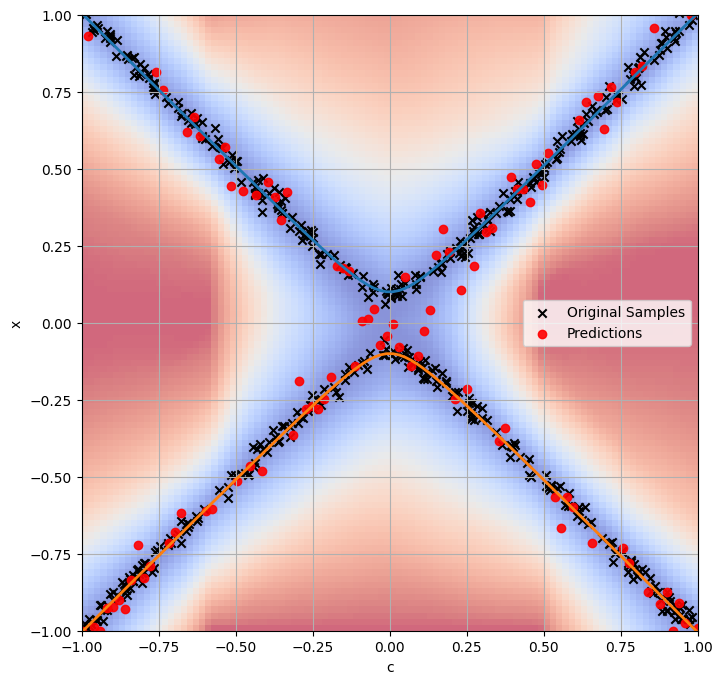


=== Training Run 2 ===
Epoch [1/100], Loss: 4.1680, LR: 0.001000
Epoch [2/100], Loss: 4.1487, LR: 0.001000
Epoch [3/100], Loss: 4.1087, LR: 0.001000
Epoch [4/100], Loss: 4.0218, LR: 0.001000
Epoch [5/100], Loss: 3.8725, LR: 0.001000
Epoch [6/100], Loss: 3.6543, LR: 0.001000
Epoch [7/100], Loss: 3.4442, LR: 0.001000
Epoch [8/100], Loss: 3.2841, LR: 0.001000
Epoch [9/100], Loss: 3.1466, LR: 0.001000
Epoch [10/100], Loss: 3.0136, LR: 0.001000
Epoch [11/100], Loss: 2.8975, LR: 0.001000
Epoch [12/100], Loss: 2.8143, LR: 0.001000
Epoch [13/100], Loss: 2.7880, LR: 0.001000
Epoch [14/100], Loss: 2.6912, LR: 0.001000
Epoch [15/100], Loss: 2.6537, LR: 0.001000
Epoch [16/100], Loss: 2.5363, LR: 0.001000
Epoch [17/100], Loss: 2.4927, LR: 0.001000
Epoch [18/100], Loss: 2.4470, LR: 0.001000
Epoch [19/100], Loss: 2.4169, LR: 0.001000
Epoch [20/100], Loss: 2.4007, LR: 0.000500
Epoch [21/100], Loss: 2.3447, LR: 0.000500
Epoch [22/100], Loss: 2.3433, LR: 0.000500
Epoch [23/100], Loss: 2.3387, LR: 0.000

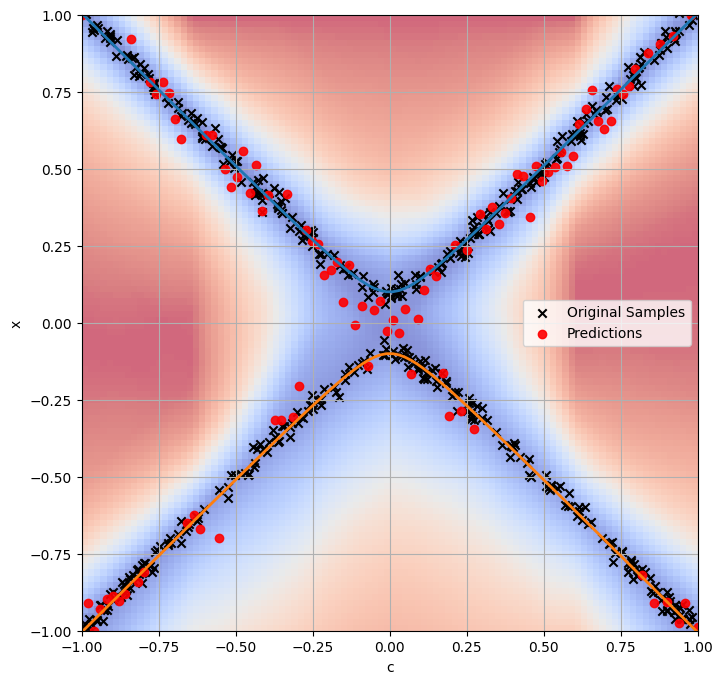


=== Training Run 3 ===
Epoch [1/100], Loss: 4.1693, LR: 0.001000
Epoch [2/100], Loss: 4.1498, LR: 0.001000
Epoch [3/100], Loss: 4.1139, LR: 0.001000
Epoch [4/100], Loss: 4.0371, LR: 0.001000
Epoch [5/100], Loss: 3.8982, LR: 0.001000
Epoch [6/100], Loss: 3.6929, LR: 0.001000
Epoch [7/100], Loss: 3.4680, LR: 0.001000
Epoch [8/100], Loss: 3.2740, LR: 0.001000
Epoch [9/100], Loss: 3.1292, LR: 0.001000
Epoch [10/100], Loss: 2.9858, LR: 0.001000
Epoch [11/100], Loss: 2.9195, LR: 0.001000
Epoch [12/100], Loss: 2.8430, LR: 0.001000
Epoch [13/100], Loss: 2.6943, LR: 0.001000
Epoch [14/100], Loss: 2.6598, LR: 0.001000
Epoch [15/100], Loss: 2.6409, LR: 0.001000
Epoch [16/100], Loss: 2.5535, LR: 0.001000
Epoch [17/100], Loss: 2.5248, LR: 0.001000
Epoch [18/100], Loss: 2.4870, LR: 0.001000
Epoch [19/100], Loss: 2.4253, LR: 0.001000
Epoch [20/100], Loss: 2.3925, LR: 0.000500
Epoch [21/100], Loss: 2.3276, LR: 0.000500
Epoch [22/100], Loss: 2.3578, LR: 0.000500
Epoch [23/100], Loss: 2.2997, LR: 0.000

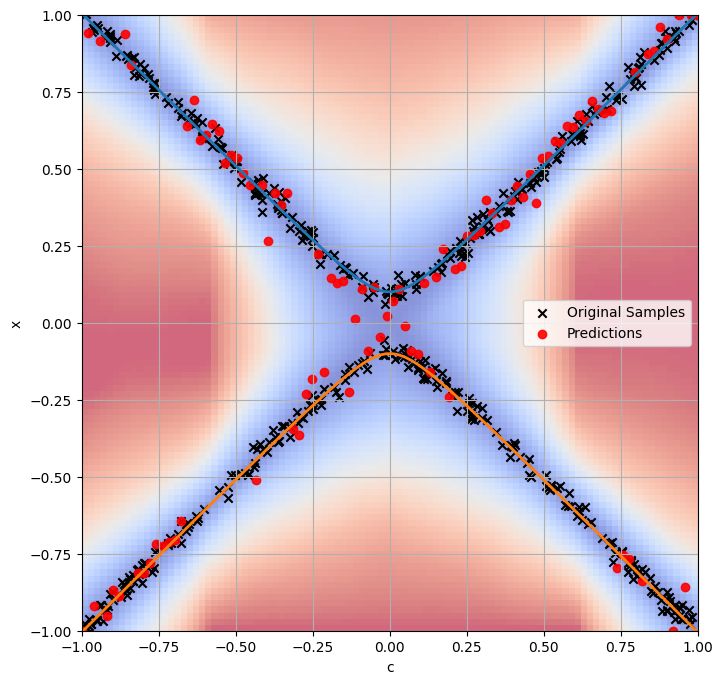


=== Training Run 4 ===
Epoch [1/100], Loss: 4.1661, LR: 0.001000
Epoch [2/100], Loss: 4.1480, LR: 0.001000
Epoch [3/100], Loss: 4.1153, LR: 0.001000
Epoch [4/100], Loss: 4.0466, LR: 0.001000
Epoch [5/100], Loss: 3.9185, LR: 0.001000
Epoch [6/100], Loss: 3.7222, LR: 0.001000
Epoch [7/100], Loss: 3.4889, LR: 0.001000
Epoch [8/100], Loss: 3.2716, LR: 0.001000
Epoch [9/100], Loss: 3.0990, LR: 0.001000
Epoch [10/100], Loss: 2.9578, LR: 0.001000
Epoch [11/100], Loss: 2.8348, LR: 0.001000
Epoch [12/100], Loss: 2.7492, LR: 0.001000
Epoch [13/100], Loss: 2.7427, LR: 0.001000
Epoch [14/100], Loss: 2.6315, LR: 0.001000
Epoch [15/100], Loss: 2.5376, LR: 0.001000
Epoch [16/100], Loss: 2.5101, LR: 0.001000
Epoch [17/100], Loss: 2.4673, LR: 0.001000
Epoch [18/100], Loss: 2.4197, LR: 0.001000
Epoch [19/100], Loss: 2.3759, LR: 0.001000
Epoch [20/100], Loss: 2.3682, LR: 0.000500
Epoch [21/100], Loss: 2.3373, LR: 0.000500
Epoch [22/100], Loss: 2.3010, LR: 0.000500
Epoch [23/100], Loss: 2.2958, LR: 0.000

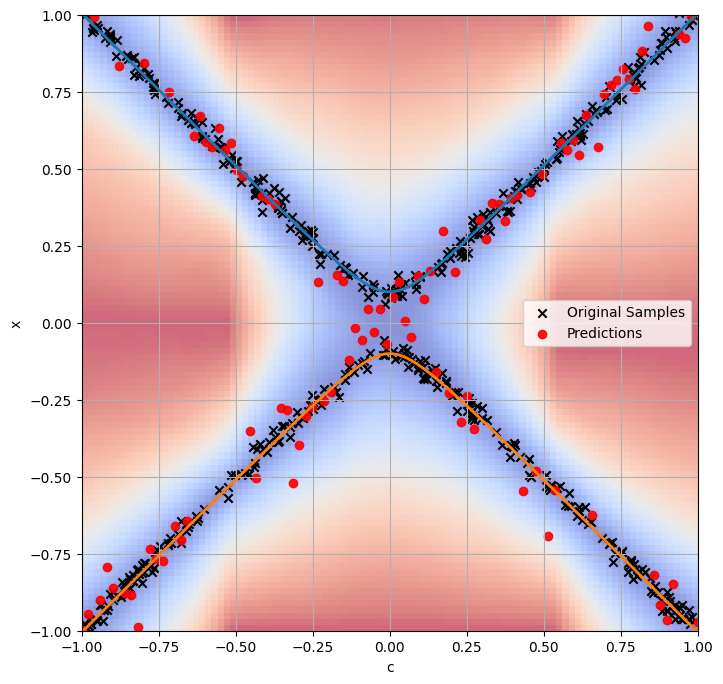


=== Training Run 5 ===
Epoch [1/100], Loss: 4.1615, LR: 0.001000
Epoch [2/100], Loss: 4.1349, LR: 0.001000
Epoch [3/100], Loss: 4.0827, LR: 0.001000
Epoch [4/100], Loss: 4.0000, LR: 0.001000
Epoch [5/100], Loss: 3.8772, LR: 0.001000
Epoch [6/100], Loss: 3.7234, LR: 0.001000
Epoch [7/100], Loss: 3.5774, LR: 0.001000
Epoch [8/100], Loss: 3.4378, LR: 0.001000
Epoch [9/100], Loss: 3.3286, LR: 0.001000
Epoch [10/100], Loss: 3.2226, LR: 0.001000
Epoch [11/100], Loss: 3.1391, LR: 0.001000
Epoch [12/100], Loss: 3.0190, LR: 0.001000
Epoch [13/100], Loss: 2.9365, LR: 0.001000
Epoch [14/100], Loss: 2.9259, LR: 0.001000
Epoch [15/100], Loss: 2.8398, LR: 0.001000
Epoch [16/100], Loss: 2.7598, LR: 0.001000
Epoch [17/100], Loss: 2.7026, LR: 0.001000
Epoch [18/100], Loss: 2.6242, LR: 0.001000
Epoch [19/100], Loss: 2.5641, LR: 0.001000
Epoch [20/100], Loss: 2.5342, LR: 0.000500
Epoch [21/100], Loss: 2.4953, LR: 0.000500
Epoch [22/100], Loss: 2.4899, LR: 0.000500
Epoch [23/100], Loss: 2.4532, LR: 0.000

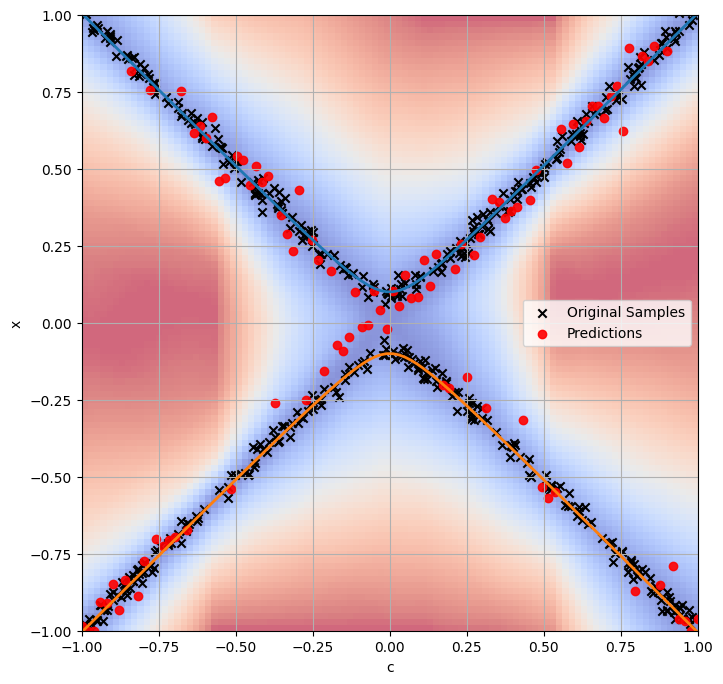

KL Divergence: 3.8332 ± 0.3406
Wasserstein Distance: 0.0098 ± 0.0007
Mode Coverage (%): 76.8000 ± 3.3106
Avgerage Modes coveraged: 1.7680 ± 0.0331


In [47]:
metrics_results = train_and_evaluate_ibc(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    hidden_size = hidden_size,
    ebm_infer = ebm_infer,
    info_nce_loss = info_nce_loss
)